In [1]:
## Load the dataset and return the first few rows
import glob
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
import dtale

Set up a regex to find the year from the filename

In [2]:
import re
year_match = re.compile('(\d{4})')

Couple of functions to transform the scoreline into useful data

In [3]:
def goals(result: str):
    '''Given a scoreline such as 6-1 returns home and away goals in a dict {home: 6, away: 1}'''
    nums = result.split('-')
    try:
        return {'home': int(nums[0]), 'away': int(nums[1])}
    except Exception:
        return {'home': -1, 'away': -1}

In [4]:
def outcome(result):
    '''Given a string of the result e.g. 6-1 categorise as either a no-score draw (1), score draw (2), home win (3) or away win (4)'''
    goals_result = goals(result)
    if goals_result['home'] == goals_result['away']:
        if goals_result['home'] == 0:
            return 1
        else:
            return 2
    elif goals_result['home'] > goals_result['away']:
        return 3
    else:
        return 4

Generate a list of available leagues from the folder names

In [5]:
league_list = glob.glob('/Users/dev/aicore/Football-predictor/Football-Dataset/*')
league_list = pd.DataFrame(league_list)
league_list.columns = ['folder']
league_list['name'] = league_list['folder'].apply(lambda x: x.split('/')[-1])
list(league_list['name'])

['championship',
 'eerste_divisie',
 'primeira_liga',
 'ligue_1',
 'segunda_division',
 '2_liga',
 'serie_a',
 'bundesliga',
 'primera_division',
 'ligue_2',
 'premier_league',
 'eredivisie',
 'segunda_liga',
 'serie_b']

Get all files in a particular folder and list their names

In [6]:
def get_files(folder):
    league_file_list = glob.glob(folder + '/*')
    league_file_list.sort()
    return league_file_list
league_list['files'] = league_list['folder'].apply(get_files)
league_list


folder              name  \
0   /Users/dev/aicore/Football-predictor/Football-...      championship   
1   /Users/dev/aicore/Football-predictor/Football-...    eerste_divisie   
2   /Users/dev/aicore/Football-predictor/Football-...     primeira_liga   
3   /Users/dev/aicore/Football-predictor/Football-...           ligue_1   
4   /Users/dev/aicore/Football-predictor/Football-...  segunda_division   
5   /Users/dev/aicore/Football-predictor/Football-...            2_liga   
6   /Users/dev/aicore/Football-predictor/Football-...           serie_a   
7   /Users/dev/aicore/Football-predictor/Football-...        bundesliga   
8   /Users/dev/aicore/Football-predictor/Football-...  primera_division   
9   /Users/dev/aicore/Football-predictor/Football-...           ligue_2   
10  /Users/dev/aicore/Football-predictor/Football-...    premier_league   
11  /Users/dev/aicore/Football-predictor/Football-...        eredivisie   
12  /Users/dev/aicore/Football-predictor/Football-...      segunda_liga   
13  /Users/dev/aicore/Football-predictor/Football-...           serie_b   

                                                files  
0   [/Users/dev/aicore/Football-predictor/Football...  
1   [/Users/dev/aicore/Football-predictor/Football...  
2   [/Users/dev/aicore/Football-predictor/Football...  
3   [/Users/dev/aicore/Football-predictor/Football...  
4   [/Users/dev/aicore/Football-predictor/Football...  
5   [/Users/dev/aicore/Football-predictor/Football...  
6   [/Users/dev/aicore/Football-predictor/Football...  
7   [/Users/dev/aicore/Football-predictor/Football...  
8   [/Users/dev/aicore/Football-predictor/Football...  
9   [/Users/dev/aicore/Football-predictor/Football...  
10  [/Users/dev/aicore/Football-predictor/Football...  
11  [/Users/dev/aicore/Football-predictor/Football...  
12  [/Users/dev/aicore/Football-predictor/Football...  
13  [/Users/dev/aicore/Football-predictor/Football...

Now run through the list of leagues (folders) and the files in them (in the files column), read in the data, and combine them together into dfs.

Results:

- `overall_team_counts` is a df showing the number of teams involved per league per season (unlikely to be consistent - and indeed not - EPL is a counterexample)
- `df_full` is the whole data of results across all leagues and seasons

In [7]:
overall_team_counts = pd.DataFrame()
df_league_lists = []
for index, league in league_list.iterrows():
    league_file_list = league['files']
    team_counts = {}
    df_list = []
    for file in league_file_list:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        year = year_match.findall(file)[0]
        if len(df.index) == 0:
            # print('No data for {}'.format(year))
            pass
        else:
            df_original = df.copy()
            df_list.append(df)
            team_counts[year] = len(df['home_team'].unique())
            # print('In {} there were {} teams'.format(year, len(df['Home_Team'].unique())))
    overall_team_counts = pd.concat([overall_team_counts, pd.Series(team_counts, name=league['name'])], axis=1)
    df_league_lists.append(pd.concat(df_list, ignore_index=True))
df_full = pd.concat(df_league_lists, ignore_index=True)
overall_team_counts.sort_index()
overall_team_counts = overall_team_counts.fillna(0).astype(int)

Use the functions defined earlier - `goals` and `outcome` - to transform the scoreline (as a string) into numerical data

In [8]:
df_full['goals'] = df_full['result'].apply(goals)
# in case we're repeating this operation
try:
    df_full = df_full.drop(['home','away'],axis=1) 
except Exception:
    pass
df_full = pd.concat([df_full, pd.json_normalize(df_full['goals'])], axis=1).drop('goals', axis=1)
# drop errors
df_full = df_full.drop(df_full[df_full.home == -1].index)
df_full['total_goals'] = df_full['home'] + df_full['away']
df_full['outcome'] = df_full['result'].apply(outcome)

In [9]:
df_full

home_team         away_team result  \
0       West Bromwich Albion  Sheffield United    0-3   
1               Swindon Town        Sunderland    0-2   
2                 Stoke City          West Ham    1-1   
3            Plymouth Argyle     Oxford United    2-0   
4                  Newcastle      Leeds United    5-2   
...                      ...               ...    ...   
146493                 Lecce              SPAL    1-2   
146494             Frosinone        Cittadella    1-1   
146495               Reggina          Vicenza     3-0   
146496               Venezia     Nuova Cosenza    3-0   
146497                Chievo              Pisa    2-0   

                                                     link  season  round  \
0       https://www.besoccer.com/match/west-bromwich/s...    1990      1   
1       https://www.besoccer.com/match/swindon-town/su...    1990      1   
2       https://www.besoccer.com/match/stoke-city/west...    1990      1   
3       https://www.besoccer.com/match/plymouth-argyle...    1990      1   
4       https://www.besoccer.com/match/newcastle-unite...    1990      1   
...                                                   ...     ...    ...   
146493  https://www.besoccer.com/match/lecce/spal-1907...    2021     33   
146494  https://www.besoccer.com/match/frosinone-calci...    2021     33   
146495  https://www.besoccer.com/match/reggina/vicenza...    2021     33   
146496  https://www.besoccer.com/match/venezia/nuova-c...    2021     33   
146497  https://www.besoccer.com/match/chievo/pisa-cal...    2021     33   

              league  home  away  total_goals  outcome  
0       championship     0     3            3        4  
1       championship     0     2            2        4  
2       championship     1     1            2        2  
3       championship     2     0            2        3  
4       championship     5     2            7        3  
...              ...   ...   ...          ...      ...  
146493       serie_b     1     2            3        4  
146494       serie_b     1     1            2        2  
146495       serie_b     3     0            3        3  
146496       serie_b     3     0            3        3  
146497       serie_b     2     0            2        3  

[146492 rows x 11 columns]

how can we extract a single league & season?

In [10]:
df = df_full.copy()

In [11]:
df[(df['season'] == 1990) & (df['league'] == 'championship')]

home_team            away_team result  \
0    West Bromwich Albion     Sheffield United    0-3   
1            Swindon Town           Sunderland    0-2   
2              Stoke City             West Ham    1-1   
3         Plymouth Argyle        Oxford United    2-0   
4               Newcastle         Leeds United    5-2   
..                    ...                  ...    ...   
547            Stoke City         Swindon Town    1-1   
548               Watford            Hull City    3-1   
549  West Bromwich Albion         Ipswich Town    1-3   
550              West Ham               Wolves    4-0   
551         Bradford City  Oldham Athletic AFC    1-1   

                                                  link  season  round  \
0    https://www.besoccer.com/match/west-bromwich/s...    1990      1   
1    https://www.besoccer.com/match/swindon-town/su...    1990      1   
2    https://www.besoccer.com/match/stoke-city/west...    1990      1   
3    https://www.besoccer.com/match/plymouth-argyle...    1990      1   
4    https://www.besoccer.com/match/newcastle-unite...    1990      1   
..                                                 ...     ...    ...   
547  https://www.besoccer.com/match/stoke-city/swin...    1990     10   
548  https://www.besoccer.com/match/watford-fc/hull...    1990     10   
549  https://www.besoccer.com/match/west-bromwich/i...    1990     10   
550  https://www.besoccer.com/match/west-ham-united...    1990     10   
551  https://www.besoccer.com/match/bradford-city/o...    1990     10   

           league  home  away  total_goals  outcome  
0    championship     0     3            3        4  
1    championship     0     2            2        4  
2    championship     1     1            2        2  
3    championship     2     0            2        3  
4    championship     5     2            7        3  
..            ...   ...   ...          ...      ...  
547  championship     1     1            2        2  
548  championship     3     1            4        3  
549  championship     1     3            4        4  
550  championship     4     0            4        3  
551  championship     1     1            2        2  

[552 rows x 11 columns]

## plot some graphs of single leagues across the seasons

<AxesSubplot:xlabel='season', ylabel='total_goals'>

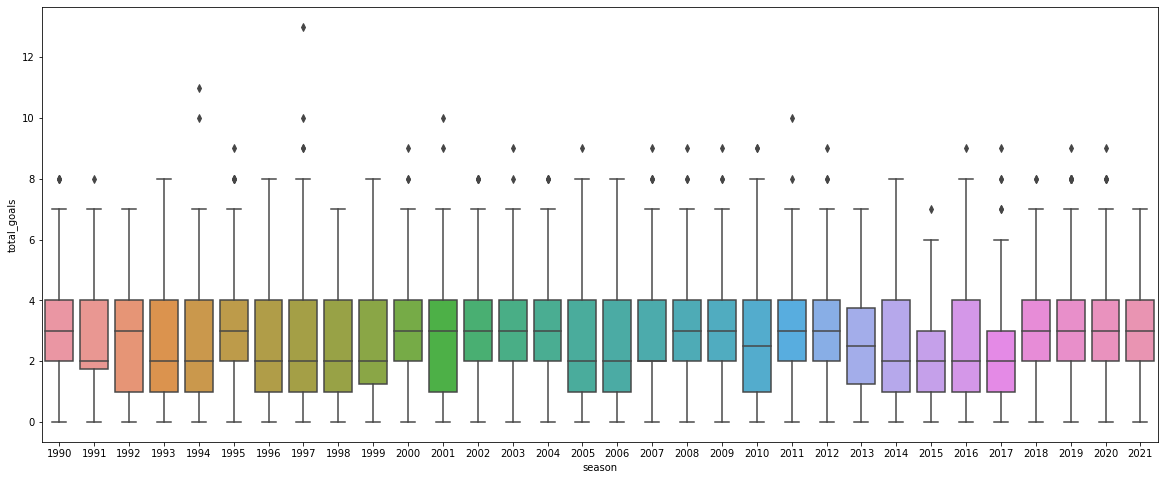

In [12]:
sns.boxplot(data=df[df['league']=='2_liga'], x='season', y='total_goals')

/Users/dev/miniforge3/envs/datascience/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


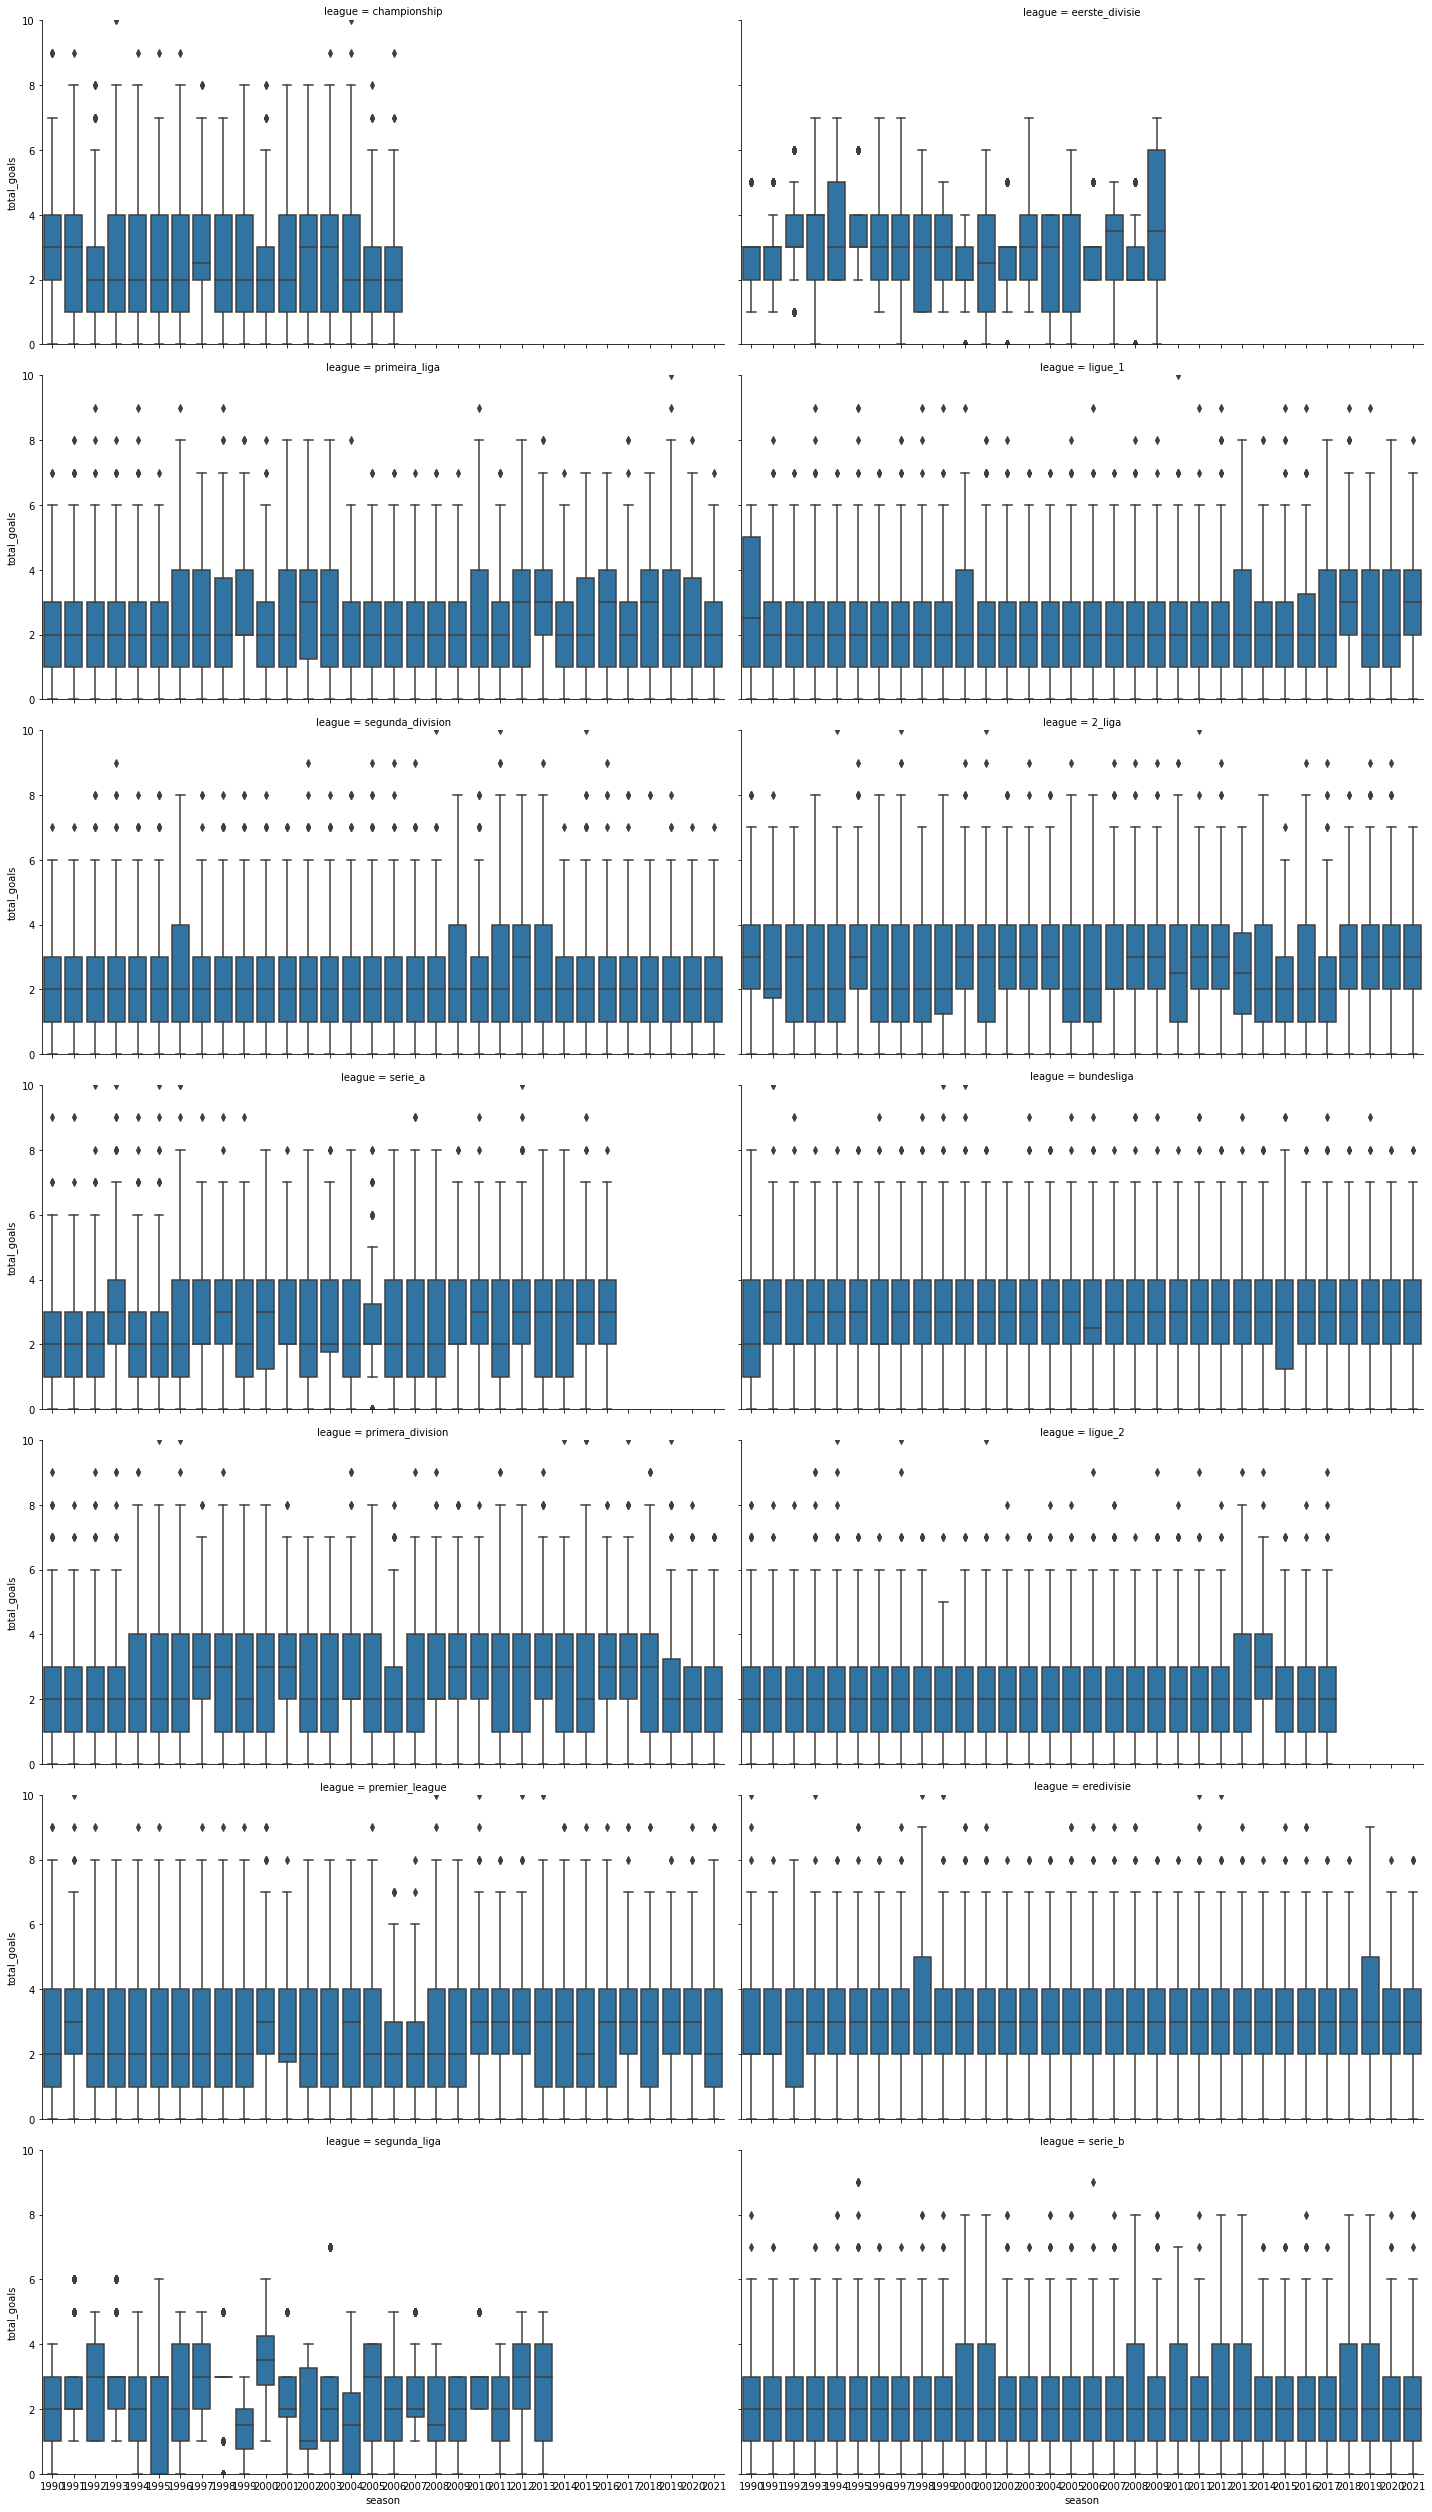

In [13]:
#https://seaborn.pydata.org/generated/seaborn.FacetGrid.html
g = sns.FacetGrid(df, col="league", col_wrap=2, height=5, aspect=2, ylim=(0, 10))
g.map(sns.boxplot, 'season', 'total_goals')

### Experiment with a stacked bar chart of different outcomes across the seasons

In [14]:
outcome_groups = df.groupby(['league','season','outcome'],as_index=False).size().set_index('season')
outcome_groups

league  outcome  size
season                        
1990     2_liga        1    31
1990     2_liga        2    84
1990     2_liga        3   188
1990     2_liga        4    77
1991     2_liga        1    40
...         ...      ...   ...
2020    serie_b        4   108
2021    serie_b        1    37
2021    serie_b        2    83
2021    serie_b        3   116
2021    serie_b        4    92

[1591 rows x 3 columns]

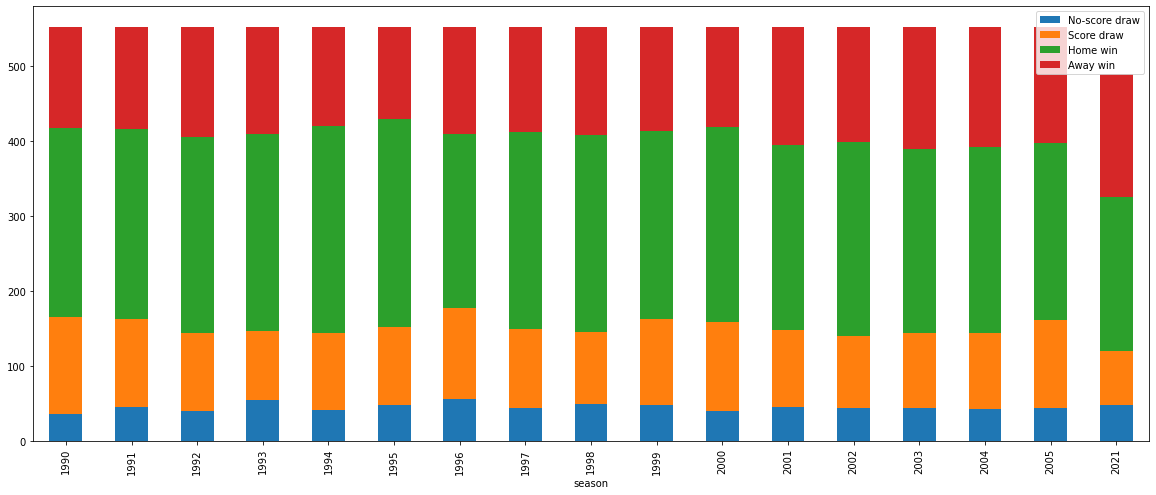

In [15]:
outcomes_per_season = outcome_groups[outcome_groups['league']=='championship'].pivot(columns='outcome')['size']
outcomes_per_season.plot(kind='bar', stacked=True)
plt.legend(['No-score draw','Score draw','Home win','Away win'])

## Now ... can we create a matrix of these?

In [16]:
len(list(league_list['name']))

14

## Trying plotly ?

This isn't working at all right now - but I'd like to debug it later so leaving it in situ for now

In [17]:
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go

In [18]:
from plotly.subplots import make_subplots

# programming_languages_by_age.index
fig = make_subplots(5, 3, subplot_titles=list(league_list['name']))
for i, league_name in enumerate(list(league_list['name'])):
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.add_trace(
        go.Bar(x=outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome').index,
            y=outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome')['size']),
        row=row, col=col
    )
fig.update_layout(showlegend=False, height=1000, title="Outcomes over the season in different leagues")
fig.update_yaxes(tickformat="%")
fig.show()

## Let's try pyplot instead

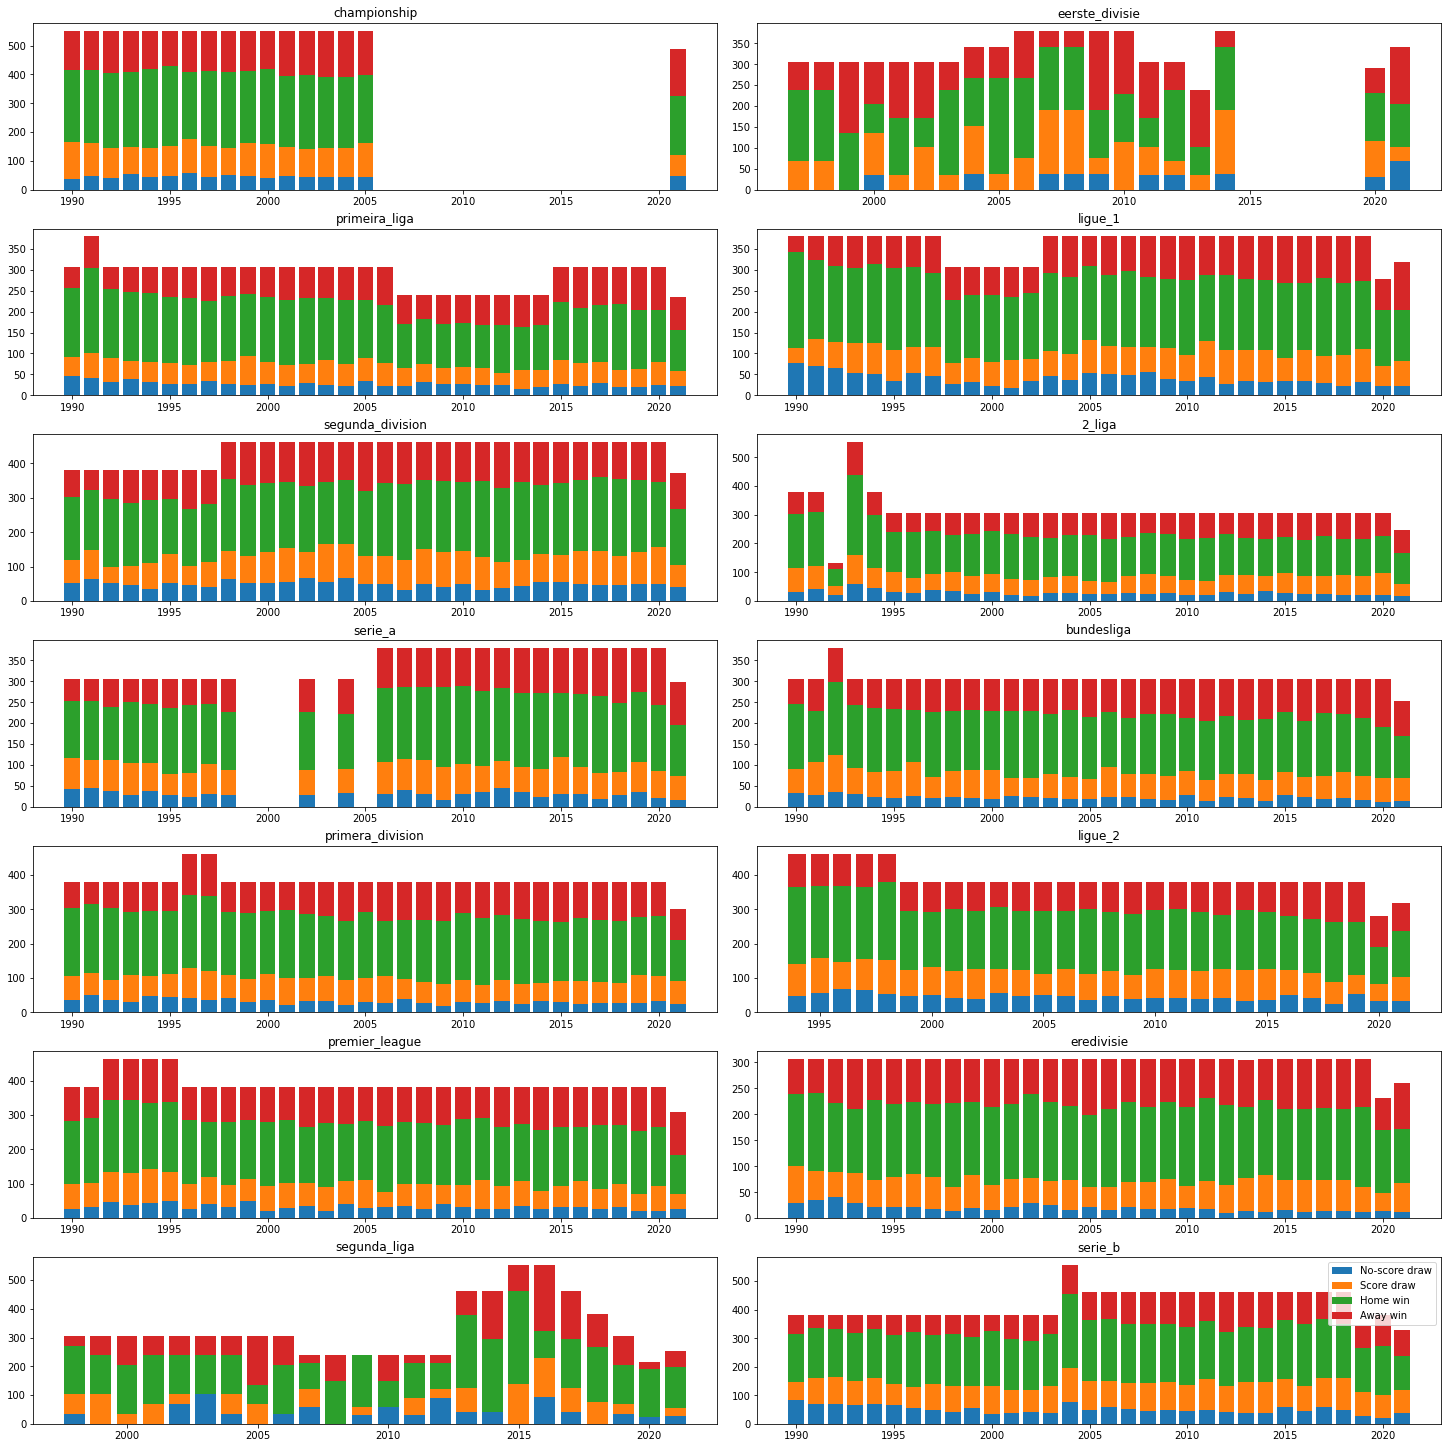

In [19]:
fig, ax = plt.subplots(7,2, constrained_layout=True, figsize=(20,20))
for i, league_name in enumerate(list(league_list['name'])):
    this_ax = ax[(i//2), i%2]
    outcomes_per_season_this_league = outcome_groups[outcome_groups['league']==league_name].pivot(columns='outcome')['size'].fillna(0)
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[2], bottom=outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[3], bottom=outcomes_per_season_this_league[2]+outcomes_per_season_this_league[1])
    this_ax.bar(outcomes_per_season_this_league.index, outcomes_per_season_this_league[4], bottom=outcomes_per_season_this_league[3]+outcomes_per_season_this_league[2]+outcomes_per_season_this_league[1])
    this_ax.set_title(league_name)
    plt.legend(['No-score draw','Score draw','Home win','Away win'])

In [20]:
# good to see how facet work in plotly express but the box plots here aren't much use to me
fig = px.box(df, x='season', y='total_goals', facet_col='league', facet_col_wrap=2)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    width=1000,height=1000
)

## try some overview stats

In [21]:
lg = df[df['league']=='eerste_divisie']
lg

home_team        away_team result  \
9321       BV Veendam         Den Bosch    1-0   
9322    MVV Maastricht        Excelsior    3-0   
9323         Dordrecht       SC Telstar    2-1   
9324      HFC Haarlem      FC Eindhoven    1-2   
9325   Go Ahead Eagles   RBC Roosendaal    2-0   
...                ...              ...    ...   
15902       SC Telstar      FC Volendam    2-2   
15903        Jong Ajax          Roda JC    0-4   
15904        Dordrecht  Go Ahead Eagles    0-0   
15905      Almere City   MVV Maastricht    0-0   
15906    De Graafschap        Den Bosch    4-2   

                                                    link  season  round  \
9321   https://www.besoccer.com/match/veendam/fc-den-...    1997      1   
9322   https://www.besoccer.com/match/mvv/excelsior/1...    1997      1   
9323   https://www.besoccer.com/match/fc-dordrecht/st...    1997      1   
9324   https://www.besoccer.com/match/haarlem/fc-eind...    1997      1   
9325   https://www.besoccer.com/match/go-ahead-eagles...    1997      1   
...                                                  ...     ...    ...   
15902  https://www.besoccer.com/match/stormvogels-tel...    2021     34   
15903  https://www.besoccer.com/match/jong-ajax/roda-...    2021     34   
15904  https://www.besoccer.com/match/fc-dordrecht/go...    2021     34   
15905  https://www.besoccer.com/match/almere-city/mvv...    2021     34   
15906  https://www.besoccer.com/match/graafschap/fc-d...    2021     34   

               league  home  away  total_goals  outcome  
9321   eerste_divisie     1     0            1        3  
9322   eerste_divisie     3     0            3        3  
9323   eerste_divisie     2     1            3        3  
9324   eerste_divisie     1     2            3        4  
9325   eerste_divisie     2     0            2        3  
...               ...   ...   ...          ...      ...  
15902  eerste_divisie     2     2            4        2  
15903  eerste_divisie     0     4            4        4  
15904  eerste_divisie     0     0            0        1  
15905  eerste_divisie     0     0            0        1  
15906  eerste_divisie     4     2            6        3  

[6586 rows x 11 columns]

In [22]:
outcome_groups[outcome_groups['league']=='eerste_divisie'].pivot(columns='outcome')['size'].fillna(0)

outcome     1      2      3      4
season                            
1997      0.0   68.0  170.0   68.0
1998      0.0   68.0  170.0   68.0
1999      0.0    0.0  136.0  170.0
2000     34.0  102.0   68.0  102.0
2001      0.0   34.0  136.0  136.0
2002      0.0  102.0   68.0  136.0
2003      0.0   34.0  204.0   68.0
2004     38.0  114.0  114.0   76.0
2005      0.0   38.0  228.0   76.0
2006      0.0   76.0  190.0  114.0
2007     38.0  152.0  152.0   38.0
2008     38.0  152.0  152.0   38.0
2009     38.0   38.0  114.0  190.0
2010      0.0  114.0  114.0  152.0
2011     34.0   68.0   68.0  136.0
2012     34.0   34.0  170.0   68.0
2013      0.0   34.0   68.0  136.0
2014     38.0  152.0  152.0   38.0
2020     29.0   87.0  116.0   58.0
2021     68.0   34.0  102.0  136.0

<AxesSubplot:xlabel='outcome', ylabel='count'>

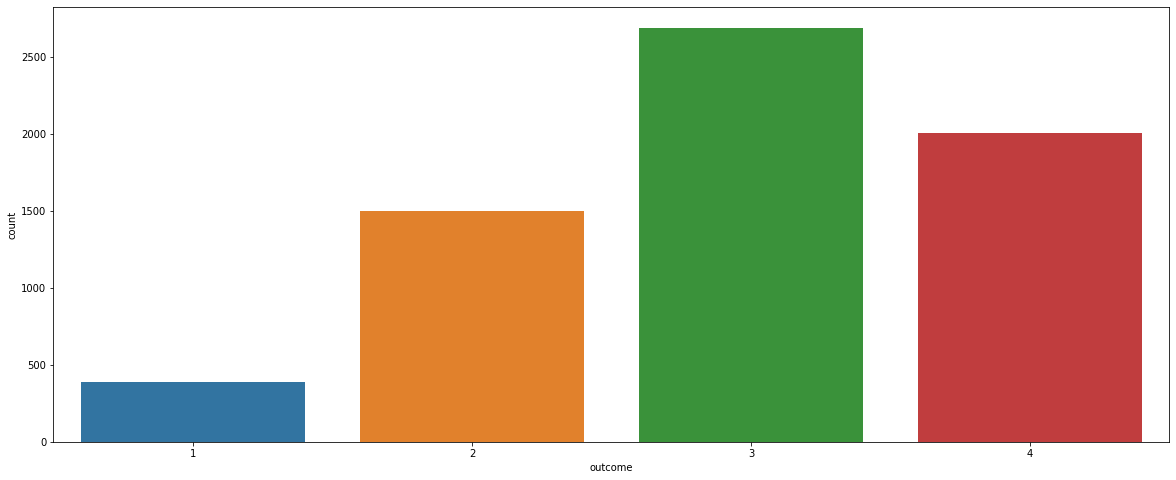

In [23]:
num_var = lg.select_dtypes(include="number")
sns.countplot(data=num_var, x='outcome')

# Stats per league

In [24]:
league_list['team_count'] = 0
for i, league_name in enumerate(list(league_list['name'])):
    lg = df[df['league']==league_name]
    seasons = list(set().union(list(lg.season.unique())))
    league_list['team_count'][i] = max([len(set(df[(df['league']==league_name) & (df['season']==season)]['home_team'])) for season in seasons])
league_list

/var/folders/3m/mch0swq10qd743jg357mbd7h0000gp/T/ipykernel_58385/11890680.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



folder              name  \
0   /Users/dev/aicore/Football-predictor/Football-...      championship   
1   /Users/dev/aicore/Football-predictor/Football-...    eerste_divisie   
2   /Users/dev/aicore/Football-predictor/Football-...     primeira_liga   
3   /Users/dev/aicore/Football-predictor/Football-...           ligue_1   
4   /Users/dev/aicore/Football-predictor/Football-...  segunda_division   
5   /Users/dev/aicore/Football-predictor/Football-...            2_liga   
6   /Users/dev/aicore/Football-predictor/Football-...           serie_a   
7   /Users/dev/aicore/Football-predictor/Football-...        bundesliga   
8   /Users/dev/aicore/Football-predictor/Football-...  primera_division   
9   /Users/dev/aicore/Football-predictor/Football-...           ligue_2   
10  /Users/dev/aicore/Football-predictor/Football-...    premier_league   
11  /Users/dev/aicore/Football-predictor/Football-...        eredivisie   
12  /Users/dev/aicore/Football-predictor/Football-...      segunda_liga   
13  /Users/dev/aicore/Football-predictor/Football-...           serie_b   

                                                files  team_count  
0   [/Users/dev/aicore/Football-predictor/Football...          24  
1   [/Users/dev/aicore/Football-predictor/Football...          10  
2   [/Users/dev/aicore/Football-predictor/Football...          20  
3   [/Users/dev/aicore/Football-predictor/Football...          20  
4   [/Users/dev/aicore/Football-predictor/Football...          22  
5   [/Users/dev/aicore/Football-predictor/Football...          24  
6   [/Users/dev/aicore/Football-predictor/Football...          20  
7   [/Users/dev/aicore/Football-predictor/Football...          20  
8   [/Users/dev/aicore/Football-predictor/Football...          22  
9   [/Users/dev/aicore/Football-predictor/Football...          22  
10  [/Users/dev/aicore/Football-predictor/Football...          22  
11  [/Users/dev/aicore/Football-predictor/Football...          18  
12  [/Users/dev/aicore/Football-predictor/Football...          12  
13  [/Users/dev/aicore/Football-predictor/Football...          24

## Aggregate across all leagues (per season)

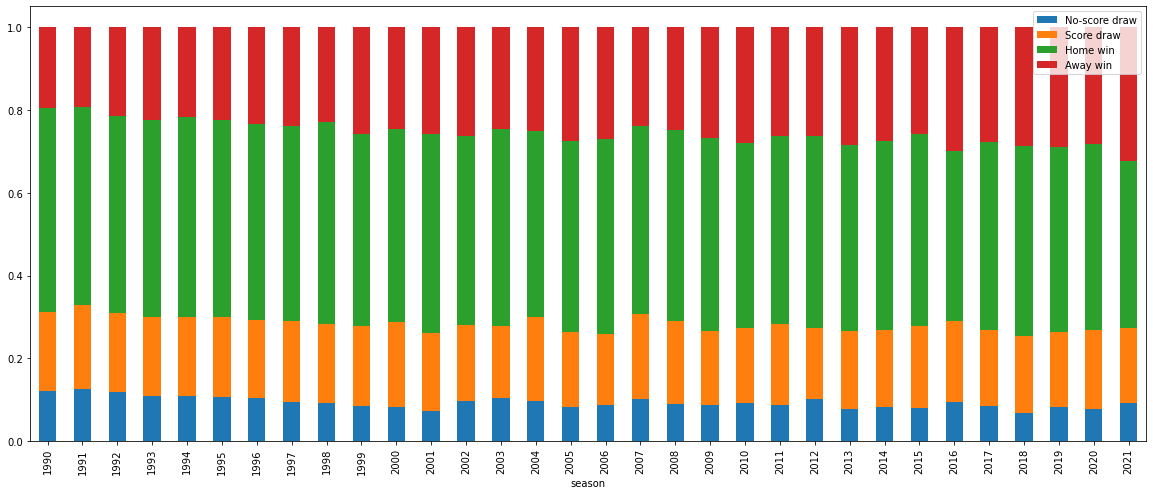

In [25]:
all_leagues_2 = df.groupby(['season','outcome'],as_index=False).size().set_index('season').pivot(columns=['outcome'])
# see https://stackoverflow.com/questions/35678874/normalize-rows-of-pandas-data-frame-by-their-sums
all_leagues_2 = all_leagues_2.div(all_leagues_2.sum(axis=1), axis=0)
all_leagues_2.plot(kind='bar', stacked=True)
plt.legend(['No-score draw','Score draw','Home win','Away win'])

## Additional datasets - join them on

## first: match info

In [26]:
match_df = pd.read_csv('additional-data/Match_Info.csv')
match_df.columns = match_df.columns.str.lower()
# match_df.info()
match_df['referee'] = match_df['referee'].str.strip().str.replace('Referee: ','')
match_df['date_dt'] = pd.to_datetime(match_df['date_new'])
match_df['link_parts'] = match_df['link'].str.split('/')
match_df['home_team'] = match_df.apply(lambda row: row['link_parts'][-3], axis=1)
match_df['away_team'] = match_df.apply(lambda row: row['link_parts'][-2], axis=1)
match_df['season'] = match_df.apply(lambda row: row['link_parts'][-1], axis=1)
match_df = match_df.drop(['date_new'], axis=1)
match_df

link  \
0             /match/saarbrucken/stuttgarter-kickers/1990   
1                    /match/sc-freiburg/unterhaching/1990   
2                        /match/vfl-osnabruck/meppen/1990   
3                  /match/rot-weiss-essen/schalke-04/1990   
4               /match/alemannia-aachen/msv-duisburg/1990   
...                                                   ...   
143343             /match/sunderland-afc/oxford-city/1999   
143344                     /match/fc-gueugnon/bastia/1994   
143345          /match/tranmere-rovers/wolverhampton/1999   
143346                       /match/sochaux/guingamp/2021   
143347  /match/huddersfield-town-fc/crystal-palace-fc/...   

                    referee  home_yellow  home_red  away_yellow  away_red  \
0         Hans-Jürgen Weber          0.0       0.0          3.0       0.0   
1               Kurt Wittke          1.0       0.0          0.0       0.0   
2            Werner Föckler          3.0       0.0          2.0       0.0   
3              Heinz Werner          2.0       0.0          2.0       0.0   
4       Hans-Peter Dellwing          1.0       0.0          1.0       0.0   
...                     ...          ...       ...          ...       ...   
143343        Anthony Leake          1.0       0.0          0.0       0.0   
143344      Jacques Poulain          0.0       0.0          0.0       0.0   
143345          Kevin Lynch          2.0       0.0          1.0       0.0   
143346             Baert A.          0.0       0.0          2.0       0.0   
143347          George Cain          1.0       0.0          1.0       0.0   

                   date_dt                                         link_parts  \
0      1989-07-29 15:00:00  [, match, saarbrucken, stuttgarter-kickers, 1990]   
1      1989-07-29 15:00:00         [, match, sc-freiburg, unterhaching, 1990]   
2      1989-07-29 15:00:00             [, match, vfl-osnabruck, meppen, 1990]   
3      1989-07-29 15:00:00       [, match, rot-weiss-essen, schalke-04, 1990]   
4      1989-07-29 15:00:00    [, match, alemannia-aachen, msv-duisburg, 1990]   
...                    ...                                                ...   
143343 1998-09-19 00:00:00       [, match, sunderland-afc, oxford-city, 1999]   
143344 1994-05-17 00:00:00               [, match, fc-gueugnon, bastia, 1994]   
143345 1999-01-08 00:00:00    [, match, tranmere-rovers, wolverhampton, 1999]   
143346 2021-02-27 19:00:00                 [, match, sochaux, guingamp, 2021]   
143347 1998-12-05 00:00:00  [, match, huddersfield-town-fc, crystal-palace...   

                   home_team            away_team season  
0                saarbrucken  stuttgarter-kickers   1990  
1                sc-freiburg         unterhaching   1990  
2              vfl-osnabruck               meppen   1990  
3            rot-weiss-essen           schalke-04   1990  
4           alemannia-aachen         msv-duisburg   1990  
...                      ...                  ...    ...  
143343        sunderland-afc          oxford-city   1999  
143344           fc-gueugnon               bastia   1994  
143345       tranmere-rovers        wolverhampton   1999  
143346               sochaux             guingamp   2021  
143347  huddersfield-town-fc    crystal-palace-fc   1999  

[143348 rows x 11 columns]

Let's look at what the team names are and see where they're not matching

In [27]:
print(df[df['league']=='premier_league']['home_team'].unique())
[ht for ht in match_df['home_team'].unique() if 'manchester' in ht or 'brighton' in ht or 'newc' in ht]

['Charlton Athletic' 'Tottenham Hotspur' 'Southampton'
 'Sheffield Wednesday' 'Queens Park Rangers' 'Nottingham Forest'
 'Man. Utd' 'Liverpool' 'Coventry City' 'Wimbledon FC' 'Arsenal'
 'Millwall' 'Luton Town' 'Everton' 'Crystal Palace' 'Chelsea'
 'Aston Villa' 'Derby County' 'Man. City' 'Norwich City'
 'Sheffield United' 'Leeds United' 'Sunderland' 'West Ham' 'Notts County'
 'Oldham Athletic AFC' 'Ipswich Town' 'Blackburn Rovers' 'Middlesbrough'
 'Newcastle' 'Swindon Town' 'Leicester' 'Bolton Wanderers' 'Barnsley'
 'Watford' 'Bradford City' 'Fulham' 'Birmingham City'
 'West Bromwich Albion' 'Portsmouth' 'Wolves' 'Wigan Athletic' 'Reading'
 'Hull City' 'Stoke City' 'Burnley' 'Blackpool' 'Swansea City'
 'Cardiff City' 'AFC Bournemouth' 'Brighton & Hove Albion'
 'Huddersfield Town']


['brighton-amp-hov',
 'newcastle-united-fc',
 'manchester-city-fc',
 'manchester-united-fc']

So let's try a fuzzy match and create a kind of hash table between the two different team name sources. This first effort is OK-ish, but not great...

In [28]:
import difflib
df_teams = df['home_team'].unique()
match_teams = match_df['home_team'].unique()


In [29]:
import pprint
matched_teams = [(d,(difflib.get_close_matches(d,match_teams,n=1,cutoff=0.4)[:1] or [None])[0]) for d in df_teams]
pprint.pprint(matched_teams)

[('West Bromwich Albion', 'west-bromwich'),
 ('Swindon Town', 'swindon-town'),
 ('Stoke City', 'stoke-city'),
 ('Plymouth Argyle', 'plymouth-argyle'),
 ('Newcastle', 'newcastle-united-fc'),
 ('Middlesbrough', 'middlesbrough-fc'),
 ('Ipswich Town', 'ipswich-town-fc'),
 ('Hull City', 'hull-city'),
 ('Brighton & Hove Albion', 'brighton-amp-hov'),
 ('Bradford City', 'bradford-city'),
 ('Blackburn Rovers', 'blackburn-rovers-fc'),
 ('Watford', 'watford-fc'),
 ('Sunderland', 'sunderland-afc'),
 ('Oldham Athletic AFC', 'oldham-athletic-afc'),
 ('AFC Bournemouth', 'afc-bournemouth'),
 ('Leeds United', 'leeds-united-afc'),
 ('West Ham', 'red-star'),
 ('Leicester', 'leicester-city-fc'),
 ('Wolves', 'alaves'),
 ('Sheffield United', 'sheffield-united'),
 ('Portsmouth', 'portsmouth'),
 ('Port Vale', 'port-vale'),
 ('Oxford United', 'oxford-united'),
 ('Barnsley', 'barnsley-fc'),
 ('Bristol City', 'bristol-city-fc'),
 ('Charlton Athletic', 'charlton-athletic-fc'),
 ('Millwall', 'millwall-fc'),
 ('Bri

Instead let's try Levenshtein. see https://www.datacamp.com/community/tutorials/fuzzy-string-python

In [30]:
from fuzzywuzzy import process
# needs a tweak for Manchester to give a helping hand on those two teams
matched_teams = [(d,(process.extractOne(d.replace('Man.','Manchester'), match_teams))[0]) for d in df_teams]

In [31]:
matched_teams

[('West Bromwich Albion', 'west-bromwich'),
 ('Swindon Town', 'swindon-town'),
 ('Stoke City', 'stoke-city'),
 ('Plymouth Argyle', 'plymouth-argyle'),
 ('Newcastle', 'newcastle-united-fc'),
 ('Middlesbrough', 'middlesbrough-fc'),
 ('Ipswich Town', 'ipswich-town-fc'),
 ('Hull City', 'hull-city'),
 ('Brighton & Hove Albion', 'brighton-amp-hov'),
 ('Bradford City', 'bradford-city'),
 ('Blackburn Rovers', 'blackburn-rovers-fc'),
 ('Watford', 'watford-fc'),
 ('Sunderland', 'sunderland-afc'),
 ('Oldham Athletic AFC', 'oldham-athletic-afc'),
 ('AFC Bournemouth', 'afc-bournemouth'),
 ('Leeds United', 'leeds-united-afc'),
 ('West Ham', 'west-ham-united'),
 ('Leicester', 'leicester-city-fc'),
 ('Wolves', 'wolverhampton'),
 ('Sheffield United', 'sheffield-united'),
 ('Portsmouth', 'portsmouth'),
 ('Port Vale', 'port-vale'),
 ('Oxford United', 'oxford-united'),
 ('Barnsley', 'barnsley-fc'),
 ('Bristol City', 'bristol-city-fc'),
 ('Charlton Athletic', 'charlton-athletic-fc'),
 ('Millwall', 'millwal

In [32]:
# check up on a problematic item from later on
[t for t in matched_teams if t[0]=='Terassa']

[]

In [33]:
def team_name_for_link(t):
    matches = [x[1] for x in matched_teams if x[0] == t]
    return (matches if len(matches)>0 else [''])[0]

In [34]:
df['link'] = df.apply(lambda row: '/'.join(['','match',team_name_for_link(row['home_team']),team_name_for_link(row['away_team']),str(row['season'])]).strip().lower().replace(' ','-'), axis=1)
df

home_team         away_team result  \
0       West Bromwich Albion  Sheffield United    0-3   
1               Swindon Town        Sunderland    0-2   
2                 Stoke City          West Ham    1-1   
3            Plymouth Argyle     Oxford United    2-0   
4                  Newcastle      Leeds United    5-2   
...                      ...               ...    ...   
146493                 Lecce              SPAL    1-2   
146494             Frosinone        Cittadella    1-1   
146495               Reggina          Vicenza     3-0   
146496               Venezia     Nuova Cosenza    3-0   
146497                Chievo              Pisa    2-0   

                                                    link  season  round  \
0             /match/west-bromwich/sheffield-united/1990    1990      1   
1                /match/swindon-town/sunderland-afc/1990    1990      1   
2                 /match/stoke-city/west-ham-united/1990    1990      1   
3              /match/plymouth-argyle/oxford-united/1990    1990      1   
4       /match/newcastle-united-fc/leeds-united-afc/1990    1990      1   
...                                                  ...     ...    ...   
146493                       /match/lecce/spal-1907/2021    2021     33   
146494        /match/frosinone-calcio/as-cittadella/2021    2021     33   
146495                /match/reggina/vicenza-calcio/2021    2021     33   
146496                 /match/venezia/nuova-cosenza/2021    2021     33   
146497                    /match/chievo/pisa-calcio/2021    2021     33   

              league  home  away  total_goals  outcome  
0       championship     0     3            3        4  
1       championship     0     2            2        4  
2       championship     1     1            2        2  
3       championship     2     0            2        3  
4       championship     5     2            7        3  
...              ...   ...   ...          ...      ...  
146493       serie_b     1     2            3        4  
146494       serie_b     1     1            2        2  
146495       serie_b     3     0            3        3  
146496       serie_b     3     0            3        3  
146497       serie_b     2     0            2        3  

[146492 rows x 11 columns]

In [35]:
# duplicates?
print(df['link'].duplicated().value_counts())
print(df[['home_team','away_team','season','league']].duplicated().value_counts())

False    130890
True      15602
Name: link, dtype: int64
False    132103
True      14389
dtype: int64


In [36]:
df.drop_duplicates(subset=['home_team','away_team','season','league'], inplace=True)

In [37]:
df2 = pd.merge(match_df, df, how="inner", on='link')
df2

link  \
0             /match/saarbrucken/stuttgarter-kickers/1990   
1                    /match/sc-freiburg/unterhaching/1990   
2                        /match/vfl-osnabruck/meppen/1990   
3                  /match/rot-weiss-essen/schalke-04/1990   
4               /match/alemannia-aachen/msv-duisburg/1990   
...                                                   ...   
114109             /match/sunderland-afc/oxford-city/1999   
114110                     /match/fc-gueugnon/bastia/1994   
114111          /match/tranmere-rovers/wolverhampton/1999   
114112                       /match/sochaux/guingamp/2021   
114113  /match/huddersfield-town-fc/crystal-palace-fc/...   

                    referee  home_yellow  home_red  away_yellow  away_red  \
0         Hans-Jürgen Weber          0.0       0.0          3.0       0.0   
1               Kurt Wittke          1.0       0.0          0.0       0.0   
2            Werner Föckler          3.0       0.0          2.0       0.0   
3              Heinz Werner          2.0       0.0          2.0       0.0   
4       Hans-Peter Dellwing          1.0       0.0          1.0       0.0   
...                     ...          ...       ...          ...       ...   
114109        Anthony Leake          1.0       0.0          0.0       0.0   
114110      Jacques Poulain          0.0       0.0          0.0       0.0   
114111          Kevin Lynch          2.0       0.0          1.0       0.0   
114112             Baert A.          0.0       0.0          2.0       0.0   
114113          George Cain          1.0       0.0          1.0       0.0   

                   date_dt                                         link_parts  \
0      1989-07-29 15:00:00  [, match, saarbrucken, stuttgarter-kickers, 1990]   
1      1989-07-29 15:00:00         [, match, sc-freiburg, unterhaching, 1990]   
2      1989-07-29 15:00:00             [, match, vfl-osnabruck, meppen, 1990]   
3      1989-07-29 15:00:00       [, match, rot-weiss-essen, schalke-04, 1990]   
4      1989-07-29 15:00:00    [, match, alemannia-aachen, msv-duisburg, 1990]   
...                    ...                                                ...   
114109 1998-09-19 00:00:00       [, match, sunderland-afc, oxford-city, 1999]   
114110 1994-05-17 00:00:00               [, match, fc-gueugnon, bastia, 1994]   
114111 1999-01-08 00:00:00    [, match, tranmere-rovers, wolverhampton, 1999]   
114112 2021-02-27 19:00:00                 [, match, sochaux, guingamp, 2021]   
114113 1998-12-05 00:00:00  [, match, huddersfield-town-fc, crystal-palace...   

                 home_team_x          away_team_x season_x        home_team_y  \
0                saarbrucken  stuttgarter-kickers     1990        Saarbrücken   
1                sc-freiburg         unterhaching     1990        SC Freiburg   
2              vfl-osnabruck               meppen     1990      VfL Osnabrück   
3            rot-weiss-essen           schalke-04     1990           RW Essen   
4           alemannia-aachen         msv-duisburg     1990   Alemannia Aachen   
...                      ...                  ...      ...                ...   
114109        sunderland-afc          oxford-city     1999         Sunderland   
114110           fc-gueugnon               bastia     1994        FC Gueugnon   
114111       tranmere-rovers        wolverhampton     1999    Tranmere Rovers   
114112               sochaux             guingamp     2021            Sochaux   
114113  huddersfield-town-fc    crystal-palace-fc     1999  Huddersfield Town   

                away_team_y result  season_y  round        league  home  away  \
0       Stuttgarter Kickers    1-0      1990      1        2_liga     1     0   
1              Unterhaching    2-3      1990      1        2_liga     2     3   
2                    Meppen    1-1      1990      1        2_liga     1     1   
3                Schalke 04    0-0      1990      1        2_liga     0     0   
4              MSV Duisburg    1-2      1990

## add team info

In [38]:
team_df = pd.read_csv('additional-data/Team_Info.csv')
team_df

Team                 City  Country  \
0    Wattenscheid 09  Bochum-Wattenscheid  Germany   
1         Hertha BSC               Berlín  Germany   
2       Unterhaching         Unterhaching  Germany   
3       Fortuna Köln              Cologne  Germany   
4       MSV Duisburg            Duisburgo  Germany   
..               ...                  ...      ...   
539           Latina               Latina    Italy   
540   Virtus Entella             Chiavari    Italy   
541    Nuova Cosenza              Cosenza    Italy   
542        Pordenone            Pordenone    Italy   
543       Bourges 18              Bourges   France   

                                Stadium Capacity              Pitch  
0                      Lohrheidestadion    16233            Natural  
1                 Olympiastadion Berlin    76065            Natural  
2                Sportpark Unterhaching    15053            Natural  
3                            Südstadion    14944            Natural  
4             Schauinsland-Reisen-Arena    31514            Natural  
..                                  ...      ...                ...  
539  Stadio Comunale Domenico Francioni     8000            Natural  
540            Stadio Comunale Chiavari     4154  Césped Artificial  
541                     Stadio San Vito    24209            Natural  
542                                 NaN     3089                NaN  
543                                 NaN   13,000                NaN  

[544 rows x 6 columns]

In [39]:
team_df.columns = team_df.columns.str.lower()
team_df['capacity'] = pd.to_numeric(team_df['capacity'].str.replace(',',''))
team_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      544 non-null    object
 1   city      544 non-null    object
 2   country   544 non-null    object
 3   stadium   447 non-null    object
 4   capacity  544 non-null    int64 
 5   pitch     447 non-null    object
dtypes: int64(1), object(5)
memory usage: 25.6+ KB


In [40]:
teams_from_team_data = set(team_df.team)
link_team_data = set(df2.home_team_x)
# originally I had this the other way round, which resulted in multiple matches
matched_teams_team_data = [(d,(process.extractOne(d.replace('Man.','Manchester'), teams_from_team_data))[0]) for d in link_team_data]

In [41]:
# should be only a single match ... working better now
[t for t in matched_teams_team_data if t[0]=='crystal-palace-fc']

[('crystal-palace-fc', 'Crystal Palace')]

In [42]:
def team_name_for_link_team_data(t):
    matches = [x[0] for x in matched_teams_team_data if x[1] == t]
    return (matches if len(matches)>0 else [''])[0]

In [43]:
team_name_for_link_team_data('Brighton Hove Alb.')

'brighton-amp-hov'

In [44]:
team_df['matched_team'] = team_df.apply(lambda row: team_name_for_link_team_data(row['team']), axis=1)
team_df

team                 city  country  \
0    Wattenscheid 09  Bochum-Wattenscheid  Germany   
1         Hertha BSC               Berlín  Germany   
2       Unterhaching         Unterhaching  Germany   
3       Fortuna Köln              Cologne  Germany   
4       MSV Duisburg            Duisburgo  Germany   
..               ...                  ...      ...   
539           Latina               Latina    Italy   
540   Virtus Entella             Chiavari    Italy   
541    Nuova Cosenza              Cosenza    Italy   
542        Pordenone            Pordenone    Italy   
543       Bourges 18              Bourges   France   

                                stadium  capacity              pitch  \
0                      Lohrheidestadion     16233            Natural   
1                 Olympiastadion Berlin     76065            Natural   
2                Sportpark Unterhaching     15053            Natural   
3                            Südstadion     14944            Natural   
4             Schauinsland-Reisen-Arena     31514            Natural   
..                                  ...       ...                ...   
539  Stadio Comunale Domenico Francioni      8000            Natural   
540            Stadio Comunale Chiavari      4154  Césped Artificial   
541                     Stadio San Vito     24209            Natural   
542                                 NaN      3089                NaN   
543                                 NaN     13000                NaN   

        matched_team  
0    wattenscheid-09  
1         hertha-bsc  
2       unterhaching  
3       fortuna-koln  
4       msv-duisburg  
..               ...  
539           latina  
540   virtus-entella  
541    nuova-cosenza  
542        pordenone  
543          bourges  

[544 rows x 7 columns]

In [164]:
# Brighton is particularly problematic! Let's see if it gets picked up
team_df[team_df.city=='Brighton']

team      city  country  \
99  Brighton Hove Alb.  Brighton  England   

                                   stadium  capacity    pitch  \
99  The American Express Community Stadium     30750  Natural   

        matched_team  
99  brighton-amp-hov

In [46]:
team_df[team_df['matched_team']=='crystal-palace-fc']

team     city  country        stadium  capacity    pitch  \
126  Crystal Palace  Londres  England  Selhurst Park     26309  Natural   

          matched_team  
126  crystal-palace-fc

In [47]:
df3 = pd.merge(df2, team_df, how="inner", left_on="home_team_x", right_on="matched_team")
df3

link            referee  \
0          /match/saarbrucken/stuttgarter-kickers/1990  Hans-Jürgen Weber   
1                  /match/saarbrucken/hannover-96/1990      Eugen Strigel   
2                       /match/saarbrucken/meppen/1990     Siegbert Rubel   
3       /match/saarbrucken/blau-weiss-1890-berlin/1990  Wilfried Heitmann   
4                /match/saarbrucken/vfl-osnabruck/1990     Karl Gangkofer   
...                                                ...                ...   
107855                       /match/bourges/nancy/1994         Marc Flosi   
107856                    /match/bourges/red-star/1994                      
107857                       /match/bourges/sedan/1994    Stéphane Moulin   
107858            /match/bourges/chamois-niortais/1994        Hervé Bayet   
107859                   /match/bourges/dunkerque/1994       Stéphane Bré   

        home_yellow  home_red  away_yellow  away_red             date_dt  \
0               0.0       0.0          3.0       0.0 1989-07-29 15:00:00   
1               0.0       0.0          3.0       0.0 1989-08-12 15:00:00   
2               0.0       0.0          3.0       0.0 1989-08-23 19:30:00   
3               0.0       0.0          0.0       0.0 1989-09-02 15:00:00   
4               1.0       0.0          2.0       0.0 1989-09-17 15:00:00   
...             ...       ...          ...       ...                 ...   
107855          0.0       0.0          0.0       1.0 1993-09-01 00:00:00   
107856          0.0       0.0          0.0       1.0 1994-03-05 00:00:00   
107857          0.0       0.0          0.0       1.0 1993-09-11 00:00:00   
107858          0.0       0.0          0.0       0.0 1993-10-27 00:00:00   
107859          0.0       0.0          0.0       1.0 1993-08-04 00:00:00   

                                               link_parts  home_team_x  \
0       [, match, saarbrucken, stuttgarter-kickers, 1990]  saarbrucken   
1               [, match, saarbrucken, hannover-96, 1990]  saarbrucken   
2                    [, match, saarbrucken, meppen, 1990]  saarbrucken   
3       [, match, saarbrucken, blau-weiss-1890-berlin,...  saarbrucken   
4             [, match, saarbrucken, vfl-osnabruck, 1990]  saarbrucken   
...                                                   ...          ...   
107855                    [, match, bourges, nancy, 1994]      bourges   
107856                 [, match, bourges, red-star, 1994]      bourges   
107857                    [, match, bourges, sedan, 1994]      bourges   
107858         [, match, bourges, chamois-niortais, 1994]      bourges   
107859                [, match, bourges, dunkerque, 1994]      bourges   

                   away_team_x season_x  home_team_y            away_team_y  \
0          stuttgarter-kickers     1990  Saarbrücken    Stuttgarter Kickers   
1                  hannover-96     1990  Saarbrücken            Hannover 96   
2                       meppen     1990  Saarbrücken                 Meppen   
3       blau-weiss-1890-berlin     1990  Saarbrücken  Blau-Weiß 1890 Berlin   
4                vfl-osnabruck     1990  Saarbrücken          VfL Osnabrück   
...                        ...      ...          ...                    ...   
107855                   nancy     1994   Bourges 18                  Nancy   
107856                red-star     1994   Bourges 18               Red Star   
107857                   sedan     1994   Bourges 18                  Sedan   
107858        chamois-niortais     1994   Bourges 18                  Niort   
107859               dunkerque     1994   Bourges 18              Dunkerque   

       result  season_y  round   league  home  away  total_goals  outcome  \
0         1-0      1990      1   2_liga     1     0            1        3   
1         2-0      1990      3   2_liga     2     0            2        3   
2         4-0      1990      5   2_liga     4     0            4        3   
3         1-1      1990      7   2_liga     1     1            2  

# Hypotheses as to which features will be important

1. capacity - some teams might play better at large stadia
1. pitch surface
1. round ... some teams might be better earlier or later in the season?
1. how about newly-promoted - would need to engineer this feature later on


# ELO

In [48]:
import pickle
elo_dict = pickle.load(open('additional-data/elo_dict.pkl', 'rb'))

In [49]:
elo_dict['https://www.besoccer.com/match/saarbrucken/stuttgarter-kickers/19903487']

{'Elo_home': 56.0, 'Elo_away': 59.0}

In [50]:
elo = pd.DataFrame.from_dict(elo_dict).transpose()
elo.columns = elo.columns.str.lower()

In [51]:
elo['link_parts'] = elo.index.str.split('/')
elo['home_team'] = elo.apply(lambda row: row['link_parts'][-3], axis=1)
elo['away_team'] = elo.apply(lambda row: row['link_parts'][-2], axis=1)
elo['season'] = elo.apply(lambda row: int(str(row['link_parts'][-1])[:4]), axis=1)
elo['link_index'] = elo.apply(lambda row: str(row['link_parts'][-1])[4:], axis=1)
elo['link'] = elo.apply(lambda row: '/'.join(['','match',row['home_team'],row['away_team'],str(row['season'])]), axis=1)
elo = elo.drop(['link_parts'], axis=1)
elo.head()

elo_home  elo_away  \
https://www.besoccer.com/match/saarbrucken/stut...      56.0      59.0   
https://www.besoccer.com/match/sc-freiburg/unte...      53.0      55.0   
https://www.besoccer.com/match/vfl-osnabruck/me...      52.0      53.0   
https://www.besoccer.com/match/rot-weiss-essen/...      53.0      62.0   
https://www.besoccer.com/match/alemannia-aachen...      57.0      52.0   

                                                           home_team  \
https://www.besoccer.com/match/saarbrucken/stut...       saarbrucken   
https://www.besoccer.com/match/sc-freiburg/unte...       sc-freiburg   
https://www.besoccer.com/match/vfl-osnabruck/me...     vfl-osnabruck   
https://www.besoccer.com/match/rot-weiss-essen/...   rot-weiss-essen   
https://www.besoccer.com/match/alemannia-aachen...  alemannia-aachen   

                                                              away_team  \
https://www.besoccer.com/match/saarbrucken/stut...  stuttgarter-kickers   
https://www.besoccer.com/match/sc-freiburg/unte...         unterhaching   
https://www.besoccer.com/match/vfl-osnabruck/me...               meppen   
https://www.besoccer.com/match/rot-weiss-essen/...           schalke-04   
https://www.besoccer.com/match/alemannia-aachen...         msv-duisburg   

                                                    season link_index  \
https://www.besoccer.com/match/saarbrucken/stut...    1990       3487   
https://www.besoccer.com/match/sc-freiburg/unte...    1990       3488   
https://www.besoccer.com/match/vfl-osnabruck/me...    1990       3489   
https://www.besoccer.com/match/rot-weiss-essen/...    1990       3490   
https://www.besoccer.com/match/alemannia-aachen...    1990       3491   

                                                                                           link  
https://www.besoccer.com/match/saarbrucken/stut...  /match/saarbrucken/stuttgarter-kickers/1990  
https://www.besoccer.com/match/sc-freiburg/unte...         /match/sc-freiburg/unterhaching/1990  
https://www.besoccer.com/match/vfl-osnabruck/me...             /match/vfl-osnabruck/meppen/1990  
https://www.besoccer.com/match/rot-weiss-essen/...       /match/rot-weiss-essen/schalke-04/1990  
https://www.besoccer.com/match/alemannia-aachen...    /match/alemannia-aachen/msv-duisburg/1990

In [52]:
elo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132111 entries, https://www.besoccer.com/match/saarbrucken/stuttgarter-kickers/19903487 to https://www.besoccer.com/match/chievo/pisa-calcio/2021103065
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   elo_home    122314 non-null  float64
 1   elo_away    122314 non-null  float64
 2   home_team   132111 non-null  object 
 3   away_team   132111 non-null  object 
 4   season      132111 non-null  int64  
 5   link_index  132111 non-null  object 
 6   link        132111 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 8.1+ MB


In [53]:
df3_teams = set(df3.home_team_x)
# lower case fixes sd-Compostela which was the only non-match
elo_teams = set(elo.home_team.str.lower())
# empty set difference shows that all teams in our data so far (df3) are included in elo
df3_teams.difference(elo_teams)

set()

In [54]:
elo.home_team = elo.home_team.str.lower()

In [55]:
df4 = pd.merge(df3, elo, how="left", on="link")
# clean up - drop some of the columns created by the joins
df4.drop(['link_parts','home_team_y','away_team_y','season_y','team','matched_team','home_team','away_team','season'], axis=1, inplace=True)
df4.rename(columns={'home_team_x':'home_team','away_team_x':'away_team','season_x':'season','home':'home_goals','away':'away_goals'}, inplace=True)
df4

link            referee  \
0          /match/saarbrucken/stuttgarter-kickers/1990  Hans-Jürgen Weber   
1                  /match/saarbrucken/hannover-96/1990      Eugen Strigel   
2                       /match/saarbrucken/meppen/1990     Siegbert Rubel   
3       /match/saarbrucken/blau-weiss-1890-berlin/1990  Wilfried Heitmann   
4                /match/saarbrucken/vfl-osnabruck/1990     Karl Gangkofer   
...                                                ...                ...   
107859                       /match/bourges/nancy/1994         Marc Flosi   
107860                    /match/bourges/red-star/1994                      
107861                       /match/bourges/sedan/1994    Stéphane Moulin   
107862            /match/bourges/chamois-niortais/1994        Hervé Bayet   
107863                   /match/bourges/dunkerque/1994       Stéphane Bré   

        home_yellow  home_red  away_yellow  away_red             date_dt  \
0               0.0       0.0          3.0       0.0 1989-07-29 15:00:00   
1               0.0       0.0          3.0       0.0 1989-08-12 15:00:00   
2               0.0       0.0          3.0       0.0 1989-08-23 19:30:00   
3               0.0       0.0          0.0       0.0 1989-09-02 15:00:00   
4               1.0       0.0          2.0       0.0 1989-09-17 15:00:00   
...             ...       ...          ...       ...                 ...   
107859          0.0       0.0          0.0       1.0 1993-09-01 00:00:00   
107860          0.0       0.0          0.0       1.0 1994-03-05 00:00:00   
107861          0.0       0.0          0.0       1.0 1993-09-11 00:00:00   
107862          0.0       0.0          0.0       0.0 1993-10-27 00:00:00   
107863          0.0       0.0          0.0       1.0 1993-08-04 00:00:00   

          home_team               away_team season result  round   league  \
0       saarbrucken     stuttgarter-kickers   1990    1-0      1   2_liga   
1       saarbrucken             hannover-96   1990    2-0      3   2_liga   
2       saarbrucken                  meppen   1990    4-0      5   2_liga   
3       saarbrucken  blau-weiss-1890-berlin   1990    1-1      7   2_liga   
4       saarbrucken           vfl-osnabruck   1990    7-1      9   2_liga   
...             ...                     ...    ...    ...    ...      ...   
107859      bourges                   nancy   1994    2-0      9  ligue_2   
107860      bourges                red-star   1994    0-1     31  ligue_2   
107861      bourges                   sedan   1994    1-2     10  ligue_2   
107862      bourges        chamois-niortais   1994    1-1     18  ligue_2   
107863      bourges               dunkerque   1994    1-1      3  ligue_2   

        home_goals  away_goals  total_goals  outcome         city  country  \
0                1           0            1        3  Saarbrücken  Germany   
1                2           0            2        3  Saarbrücken  Germany   
2                4           0            4        3  Saarbrücken  Germany   
3                1           1            2        2  Saarbrücken  Germany   
4                7           1            8        3  Saarbrücken  Germany   
...            ...         ...          ...      ...          ...      ...   
107859           2           0            2        3      Bourges   France   
107860           0           1            1        4      Bourges   France   
107861           1           2            3        4      Bourges   France   
107862           1           1            2        2      Bourges   France   
107863           1           1            2        2      Bourges   France   

                    stadium  capacity    pitch  elo_home  elo_away link_index  
0       Stadion Ludwigspark     35286  Natural      56.0      59.0       3487  
1       Stadion Ludwigspark     35286  Natural      56.0      60.0       3507  
2       Stadion Ludwigspark     35286  Natural      57.0      53.0       3533  
3       Stadion Ludwigspark   

In [56]:
fulldf = df4.copy()

# Feature engineering

## Newly-promoted teams (and newly-relegated)

Highlight which teams are new in the league this season

In [57]:
# try this for premier_league 2018 as an example
def teams(league,season):
    return set(fulldf[(fulldf['league']==league) & (fulldf['season']==season)].home_team)
pl18_teams = teams('premier_league','2018')
pl17_teams = teams('premier_league','2017')
pl18_teams.difference(pl17_teams)

{'brighton-amp-hov', 'huddersfield-town-fc', 'newcastle-united-fc'}

In [58]:
# we have to connect pairs of leagues so we can look at relegation and promotion between them

league_pairings = [
    ('ligue_1','ligue_2'),
    ('eredivisie','eerste_divisie'),
    ('premier_league','championship'),
    ('primera_division','segunda_division'),
    ('primeira_liga','segunda_liga'),
    ('serie_a','serie_b'),
    ('bundesliga','2_liga')
]

# returns the league that's connected (same country) to the one supplied, and t/f as to whether the league supplied as l is the top league
def pairing(l):
    pair = [p for p in league_pairings if l in p][0]
    return ([t for t in pair if t != l][0], l == pair[0]) 

# eg

In [59]:
def teams_new_this_season(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    return list(this_season.difference(previous_season))

def teams_gone_from_last_season(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    return list(previous_season.difference(this_season))


In [60]:
# returns a 2-tuple of (promoted teams, relegated teams) - i.e. lists of teams in this league this season who arrived by either promotion or relegation
def promoted_teams(league, season):
    previous_season = teams(league,str(int(season)-1))
    this_season = teams(league, season)
    if len(previous_season) == 0:
        return ([],[])
    new_this_season = teams_new_this_season(league, season)
    connected = pairing(league)
    if not connected[1]: # league is NOT the top league so we need to look at relegated teams too
        relegated_teams = teams_gone_from_last_season(connected[0], season)
        promoted_teams = list(set(new_this_season).difference(set(relegated_teams)))
        return (promoted_teams, relegated_teams)
    else:
        return (new_this_season, [])
    

In [61]:
promoted_teams('championship','2000')

(['fulham', 'walsall', 'manchester-city-fc'],
 ['blackburn-rovers-fc', 'nottingham-forest-fc', 'charlton-athletic-fc'])

In [62]:
leagues = list(set(fulldf.league))
seasons = list(set(fulldf.season))
df_moved_teams = pd.DataFrame(columns=leagues)
df_moved_teams['season'] = seasons
df_moved_teams.set_index('season', inplace=True)
for league in leagues:
    for season in seasons:
        df_moved_teams.at[season,league] = promoted_teams(league, season)
        
# df_moved_teams

In [63]:
fulldf['home_newly_promoted'] = fulldf.apply(lambda row: row.home_team in df_moved_teams.at[row.season,row.league][0], axis=1)
fulldf['home_newly_relegated'] = fulldf.apply(lambda row: row.home_team in df_moved_teams.at[row.season,row.league][1], axis=1)
fulldf['away_newly_promoted'] = fulldf.apply(lambda row: row.away_team in df_moved_teams.at[row.season,row.league][0], axis=1)
fulldf['away_newly_relegated'] = fulldf.apply(lambda row: row.away_team in df_moved_teams.at[row.season,row.league][1], axis=1)
# fulldf

In [64]:
# drop the items missing elo
print(fulldf.size)
fulldf.dropna(subset=['elo_home','elo_away'],inplace=True)
print(fulldf.size)

3128056
2922997


In [65]:
fulldf.sort_values('date_dt',inplace=True)

In [169]:
#  check newly promoted / relegated
dtale.show(fulldf[(fulldf['home_newly_relegated']==True) & (fulldf['away_newly_promoted']==True)])

# Cumulative goals, wins, etc

In [66]:
fulldf[['home_goals_cum','away_goals_cum']] = fulldf.groupby(by=['season','home_team']).cumsum()[['home_goals','away_goals']]
# example
# fulldf[(fulldf['season']=='2018') & (fulldf['home_team']=='brighton-amp-hov')]

# Winning / losing streaks

In [67]:
fulldf.head()

link              referee  \
40415  /match/olympique-lyonnais/olympique-marsella/1990       Michel Vautrot   
40938                          /match/metz/bordeaux/1990    Antoine de Pandis   
41440              /match/sochaux/stade-brestois-29/1990         Robert Wurtz   
40937                    /match/racing-paris/monaco/1990  Jean-Marie Lartigot   
43017          /match/sporting-toulon/saint-etienne/1990    Jean-Claude Hirtz   

       home_yellow  home_red  away_yellow  away_red    date_dt  \
40415          2.0       0.0          2.0       0.0 1989-07-21   
40938          1.0       0.0          2.0       0.0 1989-07-22   
41440          1.0       0.0          2.0       0.0 1989-07-22   
40937          1.0       0.0          1.0       0.0 1989-07-22   
43017          2.0       0.0          1.0       0.0 1989-07-22   

                home_team           away_team season result  round   league  \
40415  olympique-lyonnais  olympique-marsella   1990    1-4      1  ligue_1   
40938                metz            bordeaux   1990    0-0      1  ligue_1   
41440             sochaux   stade-brestois-29   1990    1-0      1  ligue_1   
40937        racing-paris              monaco   1990    0-0      1  ligue_1   
43017     sporting-toulon       saint-etienne   1990    2-0      1  ligue_1   

       home_goals  away_goals  total_goals  outcome     city country  \
40415           1           4            5        4     Lyon  France   
40938           0           0            0        1     Metz  France   
41440           1           0            1        3  Sochaux  France   
40937           0           0            0        1    París  France   
43017           2           0            2        3   Toulon  France   

                       stadium  capacity    pitch  elo_home  elo_away  \
40415  Parc Olympique Lyonnais     59168  Natural      72.0      81.0   
40938   Stade Saint-Symphorien     26661  Natural      76.0      83.0   
41440      Stade Auguste-Bonal     20005  Natural      78.0      73.0   
40937                      NaN     14000    Grass      72.0      82.0   
43017   Stade de Bon-Rencontre      8000      NaN      76.0      76.0   

      link_index  home_newly_promoted  home_newly_relegated  \
40415       3107                False                 False   
40938       3115                False                 False   
41440       3113                False                 False   
40937       3116                False                 False   
43017       3110                False                 False   

       away_newly_promoted  away_newly_relegated  home_goals_cum  \
40415                False                 False               1   
40938                False                 False               0   
41440                False                 False               1   
40937                False                 False               0   
43017                False                 False               2   

       away_goals_cum  
40415               4  
40938               0  
41440               0  
40937               0  
43017               0

In [68]:
df5 = fulldf.copy().set_index(['season','league']).sort_values('date_dt')

In [69]:
df5['home_win'] = df5.apply(lambda row: 1 if row['home_goals'] > row['away_goals'] else 0, axis=1)
df5['away_win'] = df5.apply(lambda row: 1 if row['home_goals'] < row['away_goals'] else 0, axis=1)
df5['draw'] = df5.apply(lambda row: 1 if row['home_goals'] == row['away_goals'] else 0, axis=1)

In [70]:
teams = list(df5['home_team'].unique())

# Counting streaks

This construction (below) of `team_res` gives decent raw data (win/lose streaks regardless of whether each game was home or away). It requires a column for every team in the dataset.

In [71]:
df6 = df5.copy().reset_index()
teams = list(df6['home_team'].unique())
# Create the new columns, one per team and a row per match, then concat them onto the main data
z = np.zeros(shape=(len(df6),len(teams)))
team_cols = pd.DataFrame(z, columns = teams)
team_results_df = pd.concat([df6, team_cols],axis=1)
# fill in each team's column with 1 for a win and -1 for a defeat against that match
# we aren't gonna count draws for now
# so the majority of the new columns will just contain a zero, and only if there's a non-draw result will there be two cols containing a 1 / -1
team_results_df.reset_index(inplace=True)
for i in team_results_df.index:
    team_results_df.loc[i, team_results_df.loc[i, 'home_team']] = 1 if team_results_df.loc[i, 'home_goals'] > team_results_df.loc[i, 'away_goals'] else -1 if team_results_df.loc[i, 'home_goals'] < team_results_df.loc[i, 'away_goals'] else 0
    team_results_df.loc[i, team_results_df.loc[i, 'away_team']] = 1 if team_results_df.loc[i, 'home_goals'] < team_results_df.loc[i, 'away_goals'] else -1 if team_results_df.loc[i, 'home_goals'] > team_results_df.loc[i, 'away_goals'] else 0

In [72]:
team_results_df.reset_index(inplace=True)
team_results_df.set_index(['season'],inplace=True)
team_results_df.sort_values('date_dt',inplace=True)
team_results_df.head()

level_0  index   league  \
season                            
1990          0      0  ligue_1   
1990          1      1  ligue_1   
1990          2      2  ligue_1   
1990          3      3  ligue_1   
1990          4      4  ligue_1   

                                                     link  \
season                                                      
1990    /match/olympique-lyonnais/olympique-marsella/1990   
1990                            /match/metz/bordeaux/1990   
1990                /match/sochaux/stade-brestois-29/1990   
1990                      /match/racing-paris/monaco/1990   
1990            /match/sporting-toulon/saint-etienne/1990   

                    referee  home_yellow  home_red  away_yellow  away_red  \
season                                                                      
1990         Michel Vautrot          2.0       0.0          2.0       0.0   
1990      Antoine de Pandis          1.0       0.0          2.0       0.0   
1990           Robert Wurtz          1.0       0.0          2.0       0.0   
1990    Jean-Marie Lartigot          1.0       0.0          1.0       0.0   
1990      Jean-Claude Hirtz          2.0       0.0          1.0       0.0   

          date_dt           home_team           away_team result  round  \
season                                                                    
1990   1989-07-21  olympique-lyonnais  olympique-marsella    1-4      1   
1990   1989-07-22                metz            bordeaux    0-0      1   
1990   1989-07-22             sochaux   stade-brestois-29    1-0      1   
1990   1989-07-22        racing-paris              monaco    0-0      1   
1990   1989-07-22     sporting-toulon       saint-etienne    2-0      1   

        home_goals  away_goals  total_goals  outcome     city country  \
season                                                                  
1990             1           4            5        4     Lyon  France   
1990             0           0            0        1     Metz  France   
1990             1           0            1        3  Sochaux  France   
1990             0           0            0        1    París  France   
1990             2           0            2        3   Toulon  France   

                        stadium  capacity    pitch  elo_home  elo_away  \
season                                                                   
1990    Parc Olympique Lyonnais     59168  Natural      72.0      81.0   
1990     Stade Saint-Symphorien     26661  Natural      76.0      83.0   
1990        Stade Auguste-Bonal     20005  Natural      78.0      73.0   
1990                        NaN     14000    Grass      72.0      82.0   
1990     Stade de Bon-Rencontre      8000      NaN      76.0      76.0   

       link_index  home_newly_promoted  home_newly_relegated  \
season                                                         
1990         3107                False                 False   
1990         3115                False                 False   
1990         3113                False                 False   
1990         3116                False                 False   
1990         3110                False                 False   

        away_newly_promoted  away_newly_relegated  home_goals_cum  \
season                                                              
1990                  False                 False               1   
1990                  False                 False               0   
1990                  False                 False               1   
1990                  False                 False               0   
1990                  False                 False               2   

        away_goals_cum  home_win  away_win  draw  olympique-lyonnais  metz  \
season                                                                       
1990                 4         0         1     0                -1.0   0.0   
1990                 0         0         0     1                 0.0  

In [73]:
team_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100793 entries, 1990 to 2021
Columns: 526 entries, level_0 to benevento-calcio
dtypes: bool(4), datetime64[ns](1), float64(497), int64(13), object(11)
memory usage: 402.6+ MB


In [74]:
# so this is almost quite nice ... giving a negative count for successive defeats and a positive count for successive wins
# the only flaw really is that draws just give zeros - we'll live with that for now, taking a draw as a neutral thing rather than a streak (which isn't really right)
season = '2018'
team = 'brighton-amp-hov'
filtered = team_results_df.loc[season].query('home_team == @team or away_team == @team')
filtered = filtered[['link','result',team,'round','date_dt']]
filtered['streak'] = filtered[team].groupby((filtered[team]!=filtered[team].shift()).cumsum()).cumsum()
filtered

link result  \
season                                                             
2018      /match/brighton-amp-hov/manchester-city-fc/2018    0-2   
2018              /match/watford-fc/brighton-amp-hov/2018    0-0   
2018           /match/brighton-amp-hov/west-bromwich/2018    3-1   
2018         /match/afc-bournemouth/brighton-amp-hov/2018    2-1   
2018     /match/brighton-amp-hov/newcastle-united-fc/2018    1-0   
2018                 /match/arsenal/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/everton-fc/2018    1-1   
2018         /match/west-ham-united/brighton-amp-hov/2018    0-3   
2018          /match/brighton-amp-hov/southampton-fc/2018    1-1   
2018        /match/swansea-city-afc/brighton-amp-hov/2018    0-1   
2018              /match/brighton-amp-hov/stoke-city/2018    2-2   
2018       /match/brighton-amp-hov/crystal-palace-fc/2018    0-0   
2018               /match/brighton-amp-hov/liverpool/2018    1-5   
2018    /match/huddersfield-town-fc/brighton-amp-hov/2018    2-0   
2018    /match/tottenham-hotspur-fc/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/burnley-fc/2018    0-0   
2018              /match/brighton-amp-hov/watford-fc/2018    1-0   
2018              /match/chelsea-fc/brighton-amp-hov/2018    2-0   
2018     /match/newcastle-united-fc/brighton-amp-hov/2018    0-0   
2018         /match/brighton-amp-hov/afc-bournemouth/2018    2-2   
2018           /match/west-bromwich/brighton-amp-hov/2018    2-0   
2018              /match/brighton-amp-hov/chelsea-fc/2018    0-4   
2018          /match/southampton-fc/brighton-amp-hov/2018    1-1   
2018         /match/brighton-amp-hov/west-ham-united/2018    3-1   
2018              /match/stoke-city/brighton-amp-hov/2018    1-1   
2018        /match/brighton-amp-hov/swansea-city-afc/2018    4-1   
2018                 /match/brighton-amp-hov/arsenal/2018    2-1   
2018              /match/everton-fc/brighton-amp-hov/2018    2-0   
2018       /match/brighton-amp-hov/leicester-city-fc/2018    0-2   
2018    /match/brighton-amp-hov/huddersfield-town-fc/2018    1-1   
2018       /match/crystal-palace-fc/brighton-amp-hov/2018    3-2   
2018    /match/brighton-amp-hov/tottenham-hotspur-fc/2018    1-1   
2018              /match/burnley-fc/brighton-amp-hov/2018    0-0   
2018    /match/brighton-amp-hov/manchester-united-fc/2018    1-0   
2018      /match/manchester-city-fc/brighton-amp-hov/2018    3-1   
2018               /match/liverpool/brighton-amp-hov/2018    4-0   

        brighton-amp-hov  round             date_dt  streak  
season                                                       
2018                -1.0      1 2017-08-12 18:30:00    -1.0  
2018                 0.0      3 2017-08-26 16:00:00     0.0  
2018                 1.0      4 2017-09-09 16:00:00     1.0  
2018                -1.0      5 2017-09-15 21:00:00    -1.0  
2018                 1.0      6 2017-09-24 17:00:00     1.0  
2018                -1.0      7 2017-10-01 13:00:00    -1.0  
2018                 0.0      8 2017-10-15 14:30:00     0.0  
2018                 1.0      9 2017-10-20 21:00:00     1.0  
2018                 0.0     10 2017-10-29 14:30:00     0.0  
2018                 1.0     11 2017-11-04 16:00:00     1.0  
2018                 0.0     12 2017-11-20 21:00:00     0.0  
2018                 0.0     14 2017-11-28 20:45:00     0.0  
2018                -1.0     15 2017-12-02 16:00:00    -1.0  
2018                -1.0     16 2017-12-09 16:00:00    -2.0  
2018                -1.0     17 2017-12-13 21:00:00    -3.0  
2018                 0.0     18 2017-12-16 16:00:00     0.0  
2018                 1.0     19 2017-12-23 16:00:00     1.0  
2018                -1.0     20 2017-12-26 16:00:00    -1.0  
2018                 0.0     21 2017-12-30 16:00:00     0.0  
2018                 0.0     22 2018-01-01 13:30:00     0.0  
2018                -1.0     23 2018-01-13 16:00:00    -1.0  
2018                -1.0     24 2018-01-20

In [75]:
# create new cols containing 
def count_streaks(season, team):
    filtered = team_results_df.loc[season].query('home_team == @team or away_team == @team')
    filtered = filtered[['link','result',team,'round','date_dt']].sort_values('date_dt')
    # calculate streaks
    filtered['start_of_streak'] = filtered[team].ne(filtered[team].shift())
    filtered['streak_id'] = filtered['start_of_streak'].cumsum()
    filtered['streak_result'] = filtered[team]
    filtered['streak_counter'] = filtered.groupby('streak_id').cumcount()
    filtered = filtered[['link','streak_counter','streak_result',team]]
    filtered.rename({'streak_counter': team+'_streak','streak_result':team+'_streak_result'},axis=1,inplace=True)
    return filtered


In [76]:
# test it
count_streaks('2018','brighton-amp-hov')

link  \
season                                                      
2018      /match/brighton-amp-hov/manchester-city-fc/2018   
2018              /match/watford-fc/brighton-amp-hov/2018   
2018           /match/brighton-amp-hov/west-bromwich/2018   
2018         /match/afc-bournemouth/brighton-amp-hov/2018   
2018     /match/brighton-amp-hov/newcastle-united-fc/2018   
2018                 /match/arsenal/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/everton-fc/2018   
2018         /match/west-ham-united/brighton-amp-hov/2018   
2018          /match/brighton-amp-hov/southampton-fc/2018   
2018        /match/swansea-city-afc/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/stoke-city/2018   
2018       /match/brighton-amp-hov/crystal-palace-fc/2018   
2018               /match/brighton-amp-hov/liverpool/2018   
2018    /match/huddersfield-town-fc/brighton-amp-hov/2018   
2018    /match/tottenham-hotspur-fc/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/burnley-fc/2018   
2018              /match/brighton-amp-hov/watford-fc/2018   
2018              /match/chelsea-fc/brighton-amp-hov/2018   
2018     /match/newcastle-united-fc/brighton-amp-hov/2018   
2018         /match/brighton-amp-hov/afc-bournemouth/2018   
2018           /match/west-bromwich/brighton-amp-hov/2018   
2018              /match/brighton-amp-hov/chelsea-fc/2018   
2018          /match/southampton-fc/brighton-amp-hov/2018   
2018         /match/brighton-amp-hov/west-ham-united/2018   
2018              /match/stoke-city/brighton-amp-hov/2018   
2018        /match/brighton-amp-hov/swansea-city-afc/2018   
2018                 /match/brighton-amp-hov/arsenal/2018   
2018              /match/everton-fc/brighton-amp-hov/2018   
2018       /match/brighton-amp-hov/leicester-city-fc/2018   
2018    /match/brighton-amp-hov/huddersfield-town-fc/2018   
2018       /match/crystal-palace-fc/brighton-amp-hov/2018   
2018    /match/brighton-amp-hov/tottenham-hotspur-fc/2018   
2018              /match/burnley-fc/brighton-amp-hov/2018   
2018    /match/brighton-amp-hov/manchester-united-fc/2018   
2018      /match/manchester-city-fc/brighton-amp-hov/2018   
2018               /match/liverpool/brighton-amp-hov/2018   

        brighton-amp-hov_streak  brighton-amp-hov_streak_result  \
season                                                            
2018                          0                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                             0.0   
2018                          1                             0.0   
2018                          0                            -1.0   
2018                          1                            -1.0   
2018                          2                            -1.0   
2018                          0                             0.0   
2018                          0                             1.0   
2018                          0                            -1.0   
2018                          0                             0.0   
2018                          1                             0.0   
2018                          0                            -1.0   
2018                          1                            -1.0   
2018                          0                             0.0   
2018                          0                            

In [77]:
# do the count_streaks fn for each team in each season
# and collect the dfs in a list
cumul_dfs = []
for season in seasons:
    for team in teams:
        cumul_dfs.append(count_streaks(str(season), team))


In [78]:
# drop the empty ones (dunno why there are so many?? perhaps this is where there aren't any streaks so everything zero, but I suspect it's something more sinister???)
print(len(cumul_dfs))
streak_dfs = [df for df in cumul_dfs if not df.empty]
print(len(streak_dfs))

14880
6468


In [79]:
# concat all those dfs together so we've got all the teams' streaks 
# in this combined df we'll get all the different columns back, most of which will be full of NaN, but one set of 3 cols in each row will have content
all_streaks_df = pd.concat(streak_dfs)
all_streaks_df.reset_index(inplace=True)

/var/folders/3m/mch0swq10qd743jg357mbd7h0000gp/T/ipykernel_58385/2735847363.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [80]:
# check what it looks like
all_streaks_df.loc[0]

season                                                                 1991
link                                /match/bordeaux/olympique-lyonnais/1991
olympique-lyonnais_streak                                               0.0
olympique-lyonnais_streak_result                                        0.0
olympique-lyonnais                                                      0.0
                                                     ...                   
sas-epinal_streak_result                                                NaN
sas-epinal                                                              NaN
charleville_streak                                                      NaN
charleville_streak_result                                               NaN
charleville                                                             NaN
Name: 0, Length: 1397, dtype: object

In [81]:
# return a pair of values, representing the home streak = length * sign (positive for win, negative for loss) , away streak
# each row will have only one team, and so either home or away will be zero, the other will be real data (possibly zero if either no streak or a streak of draws)
def home_or_away(row):
    # which team cols are non-NaN?
    first_non_null_col = row[2:].first_valid_index()
    team_name = first_non_null_col.split('_')[0]
    link_parts = row['link'].split('/')
    # print(link_parts, team_name)
    home_away = 'home' if team_name==link_parts[2] else 'away'
    # we'll return home_streak * home_streak_result, away_streak * away_streak_result
    if home_away == 'home':
        return row[team_name + '_streak'] * row[team_name + '_streak_result'], 0
    else:
        return 0, row[team_name + '_streak'] * row[team_name + '_streak_result']

In [82]:
# arbitrary check
locno = 24
print(all_streaks_df.loc[locno])
print(home_or_away(all_streaks_df.loc[locno]))

season                                                                          1991
link                                /match/stade-brestois-29/olympique-lyonnais/1991
olympique-lyonnais_streak                                                        1.0
olympique-lyonnais_streak_result                                                -1.0
olympique-lyonnais                                                              -1.0
                                                          ...                       
sas-epinal_streak_result                                                         NaN
sas-epinal                                                                       NaN
charleville_streak                                                               NaN
charleville_streak_result                                                        NaN
charleville                                                                      NaN
Name: 24, Length: 1397, dtype: object
(0, -1.0)


In [83]:
# use this function to add the home_stream and away_streak cols to the df
all_streaks_df['home_streak'], all_streaks_df['away_streak'] = zip(*all_streaks_df.apply(home_or_away, axis=1))

In [84]:
# and then just keep the key columns, drop the teams now that they've been copied into the home_streak and away_streak cols - we're done with them
just_streaks_df = all_streaks_df[['link','home_streak','away_streak']].copy()

In [85]:
just_streaks_df.sample(20)

link  home_streak  \
56204                      /match/bordeaux/auxerre/1994          0.0   
28917                          /match/roma/bologna/2013         -0.0   
33901              /match/stoke-city/west-bromwich/2017          0.0   
163390  /match/blackburn-rovers-fc/derby-county-fc/1999          0.0   
145793                       /match/xerez/espanyol/2010          0.0   
56029                     /match/angers-sco/monaco/1994          0.0   
179101               /match/schalke-04/hannover-96/2012          0.0   
33632               /match/fc-utrecht/ado-den-haag/2017          0.0   
18353                    /match/heracles/willem-ii/2009          0.0   
17103                /match/stade-brestois-29/lens/2009          1.0   
13213         /match/rotherham-united/grimsby-town/2002          0.0   
159916               /match/rio-ave/pacos-ferreira/2020          0.0   
195461    /match/olympique-marsella/olympique-ales/1996          0.0   
26164                  /match/rm-castilla/mirandes/2014          0.0   
41336        /match/ascoli/salernitana-calcio-1919/2018         -1.0   
71674        /match/borussia-dortmund/hamburger-sv/1992          0.0   
31866                     /match/fulham/reading-fc/2013          0.0   
172050              /match/olympique-lyonnais/metz/2000          1.0   
161107                     /match/stade-reims/nice/2020          0.0   
32241                /match/us-grosseto/asd-spezia/2013          0.0   

        away_streak  
56204          -0.0  
28917           0.0  
33901           0.0  
163390          0.0  
145793          0.0  
56029           0.0  
179101          0.0  
33632           0.0  
18353           0.0  
17103           0.0  
13213           0.0  
159916          0.0  
195461         -5.0  
26164           1.0  
41336           0.0  
71674           0.0  
31866           0.0  
172050          0.0  
161107          0.0  
32241           0.0

In [86]:
# combine the pairs together - for the same match (=link) we have the home_streak in one row and away_streak in another
merged_streaks_df = just_streaks_df.groupby('link').sum()

In [87]:
# check this
merged_streaks_df.head()

home_streak  away_streak
link                                                                
/match/1-fc-union-berlin/1860-munchen/2010          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2011          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2012         -1.0          3.0
/match/1-fc-union-berlin/1860-munchen/2013          0.0          0.0
/match/1-fc-union-berlin/1860-munchen/2014          0.0          0.0

In [88]:
# here's an example in the head above for us to check
# if your head comes up differently, just change the match to see what's happening
# but you should end up with two rows matching the link, one with a home_streak and the other with an away_streak
just_streaks_df[just_streaks_df['link']=='/match/1-fc-union-berlin/1860-munchen/2012']

link  home_streak  away_streak
181740  /match/1-fc-union-berlin/1860-munchen/2012          0.0          3.0
183133  /match/1-fc-union-berlin/1860-munchen/2012         -1.0          0.0

In [89]:
# merge that data onto the main df
df7 = df6.merge(merged_streaks_df, on='link')

In [90]:
df7.head()

season   league                                               link  \
0   1990  ligue_1  /match/olympique-lyonnais/olympique-marsella/1990   
1   1990  ligue_1                          /match/metz/bordeaux/1990   
2   1990  ligue_1              /match/sochaux/stade-brestois-29/1990   
3   1990  ligue_1                    /match/racing-paris/monaco/1990   
4   1990  ligue_1          /match/sporting-toulon/saint-etienne/1990   

               referee  home_yellow  home_red  away_yellow  away_red  \
0       Michel Vautrot          2.0       0.0          2.0       0.0   
1    Antoine de Pandis          1.0       0.0          2.0       0.0   
2         Robert Wurtz          1.0       0.0          2.0       0.0   
3  Jean-Marie Lartigot          1.0       0.0          1.0       0.0   
4    Jean-Claude Hirtz          2.0       0.0          1.0       0.0   

     date_dt           home_team           away_team result  round  \
0 1989-07-21  olympique-lyonnais  olympique-marsella    1-4      1   
1 1989-07-22                metz            bordeaux    0-0      1   
2 1989-07-22             sochaux   stade-brestois-29    1-0      1   
3 1989-07-22        racing-paris              monaco    0-0      1   
4 1989-07-22     sporting-toulon       saint-etienne    2-0      1   

   home_goals  away_goals  total_goals  outcome     city country  \
0           1           4            5        4     Lyon  France   
1           0           0            0        1     Metz  France   
2           1           0            1        3  Sochaux  France   
3           0           0            0        1    París  France   
4           2           0            2        3   Toulon  France   

                   stadium  capacity    pitch  elo_home  elo_away link_index  \
0  Parc Olympique Lyonnais     59168  Natural      72.0      81.0       3107   
1   Stade Saint-Symphorien     26661  Natural      76.0      83.0       3115   
2      Stade Auguste-Bonal     20005  Natural      78.0      73.0       3113   
3                      NaN     14000    Grass      72.0      82.0       3116   
4   Stade de Bon-Rencontre      8000      NaN      76.0      76.0       3110   

   home_newly_promoted  home_newly_relegated  away_newly_promoted  \
0                False                 False                False   
1                False                 False                False   
2                False                 False                False   
3                False                 False                False   
4                False                 False                False   

   away_newly_relegated  home_goals_cum  away_goals_cum  home_win  away_win  \
0                 False               1               4         0         1   
1                 False               0               0         0         0   
2                 False               1               0         1         0   
3                 False               0               0         0         0   
4                 False               2               0         1         0   

   draw  home_streak  away_streak  
0     0          0.0          0.0  
1     1          0.0          0.0  
2     0          0.0          0.0  
3     1          0.0          0.0  
4     0          0.0          0.0

In [91]:
# and check out the data for one season and one team, which is where we can check it
season = '2018'
team = 'brighton-amp-hov'
df7[(df7['season']==season) & ((df7['home_team']==team) | (df7['away_team']==team))].sort_values('date_dt')[['link','home_team','away_team','result','home_streak','away_streak']]

link  \
88702    /match/brighton-amp-hov/manchester-city-fc/2018   
88827            /match/watford-fc/brighton-amp-hov/2018   
88934         /match/brighton-amp-hov/west-bromwich/2018   
89009       /match/afc-bournemouth/brighton-amp-hov/2018   
89189   /match/brighton-amp-hov/newcastle-united-fc/2018   
89267               /match/arsenal/brighton-amp-hov/2018   
89375            /match/brighton-amp-hov/everton-fc/2018   
89413       /match/west-ham-united/brighton-amp-hov/2018   
89556        /match/brighton-amp-hov/southampton-fc/2018   
89619      /match/swansea-city-afc/brighton-amp-hov/2018   
89768            /match/brighton-amp-hov/stoke-city/2018   
89862     /match/brighton-amp-hov/crystal-palace-fc/2018   
89905             /match/brighton-amp-hov/liverpool/2018   
89991  /match/huddersfield-town-fc/brighton-amp-hov/2018   
90064  /match/tottenham-hotspur-fc/brighton-amp-hov/2018   
90096            /match/brighton-amp-hov/burnley-fc/2018   
90196            /match/brighton-amp-hov/watford-fc/2018   
90221            /match/chelsea-fc/brighton-amp-hov/2018   
90243   /match/newcastle-united-fc/brighton-amp-hov/2018   
90251       /match/brighton-amp-hov/afc-bournemouth/2018   
90321         /match/west-bromwich/brighton-amp-hov/2018   
90386            /match/brighton-amp-hov/chelsea-fc/2018   
90542        /match/southampton-fc/brighton-amp-hov/2018   
90575       /match/brighton-amp-hov/west-ham-united/2018   
90671            /match/stoke-city/brighton-amp-hov/2018   
90838      /match/brighton-amp-hov/swansea-city-afc/2018   
90965               /match/brighton-amp-hov/arsenal/2018   
91017            /match/everton-fc/brighton-amp-hov/2018   
91211     /match/brighton-amp-hov/leicester-city-fc/2018   
91297  /match/brighton-amp-hov/huddersfield-town-fc/2018   
91389     /match/crystal-palace-fc/brighton-amp-hov/2018   
91454  /match/brighton-amp-hov/tottenham-hotspur-fc/2018   
91594            /match/burnley-fc/brighton-amp-hov/2018   
91662  /match/brighton-amp-hov/manchester-united-fc/2018   
91745    /match/manchester-city-fc/brighton-amp-hov/2018   
91803             /match/liverpool/brighton-amp-hov/2018   

                  home_team             away_team result  home_streak  \
88702      brighton-amp-hov    manchester-city-fc    0-2          0.0   
88827            watford-fc      brighton-amp-hov    0-0          0.0   
88934      brighton-amp-hov         west-bromwich    3-1          0.0   
89009       afc-bournemouth      brighton-amp-hov    2-1          0.0   
89189      brighton-amp-hov   newcastle-united-fc    1-0          0.0   
89267               arsenal      brighton-amp-hov    2-0          1.0   
89375      brighton-amp-hov            everton-fc    1-1          0.0   
89413       west-ham-united      brighton-amp-hov    0-3          0.0   
89556      brighton-amp-hov        southampton-fc    1-1          0.0   
89619      swansea-city-afc      brighton-amp-hov    0-1         -2.0   
89768      brighton-amp-hov            stoke-city    2-2          0.0   
89862      brighton-amp-hov     crystal-palace-fc    0-0          0.0   
89905      brighton-amp-hov             liverpool    1-5          0.0   
89991  huddersfield-town-fc      brighton-amp-hov    2-0          0.0   
90064  tottenham-hotspur-fc      brighton-amp-hov    2-0          1.0   
90096      brighton-amp-hov            burnley-fc    0-0          0.0   
90196      brighton-amp-hov            watford-fc    1-0          0.0   
90221            chelsea-fc      brighton-amp-hov    2-0          0.0   
90243   newcastle-united-fc      brighton-amp-hov    0-0          0.0   
90251      brighton-amp-hov       afc-bournemouth    2-2          0.0   
90321         west-bromwich      brighton-amp-hov    2-0          0.0   
90386      brighton-amp-hov            chelsea-fc    0-4         -1.0   
90542        southampton-fc      brighton-amp-hov    1-1          0.0   
90575      brighton-amp-hov       west-ham-united    3-1          0.0   
90671 

In [172]:
# see https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
def bool_to_int(s: pd.Series) -> pd.Series:
    return 1 if s else 0 # s.replace({True: 1, False: 0})
    
# df7_ints = df7.assign(**{c: lambda df: df[c].pipe(bool_to_int) for c in ['home_newly_promoted','home_newly_relegated','away_newly_promoted','away_newly_relegated']})

In [175]:
df7['home_newly_promoted'] = df7['home_newly_promoted'].apply(bool_to_int)
df7['away_newly_promoted'] = df7['away_newly_promoted'].apply(bool_to_int)
df7['home_newly_relegated'] = df7['home_newly_relegated'].apply(bool_to_int)
df7['away_newly_relegated'] = df7['away_newly_relegated'].apply(bool_to_int)

In [177]:
df7_trimmed = df7.drop(columns=['link','referee','home_yellow','home_red','away_yellow','away_red','date_dt','home_team','away_team','result','round','home_goals','away_goals','total_goals','city','country','stadium','pitch','link_index','home_win','away_win','draw'])

In [178]:
df7_trimmed['season'] = df7_trimmed['season'].apply(lambda s: 2022-int(s))

In [179]:
df7_trimmed['capacity'] = df7_trimmed['capacity']/10000

In [180]:
df7_trimmed['away_newly_promoted'].value_counts()

0    86159
1    14634
Name: away_newly_promoted, dtype: int64

In [181]:
dtale.show(df7_trimmed[(df7_trimmed['home_newly_promoted']==1) & (df7_trimmed['away_newly_relegated']==1)])

## Additional features we could consider...

- some kind of measure of how many games each team has played in recent days; single float with high numbers for very recent and lower for more distant - kind of $$\sum_{i=1}^{10} \frac{m_i}{2^{i-1}}$$ where $m_i$ is a binary as to whether a match was played $i$ days ago
- day of week that the match was played
- weather conditions on the day in question? (but unlikely to be of use - same for both teams)

In [182]:
df_numeric = df7_trimmed.drop(columns='league')
df_numeric.dtypes

season                    int64
outcome                   int64
capacity                float64
elo_home                float64
elo_away                float64
home_newly_promoted       int64
home_newly_relegated      int64
away_newly_promoted       int64
away_newly_relegated      int64
home_goals_cum            int64
away_goals_cum            int64
home_streak             float64
away_streak             float64
dtype: object

In [183]:
df_numeric.insert(0, 'outcome', df_numeric.pop('outcome'))

<AxesSubplot:>

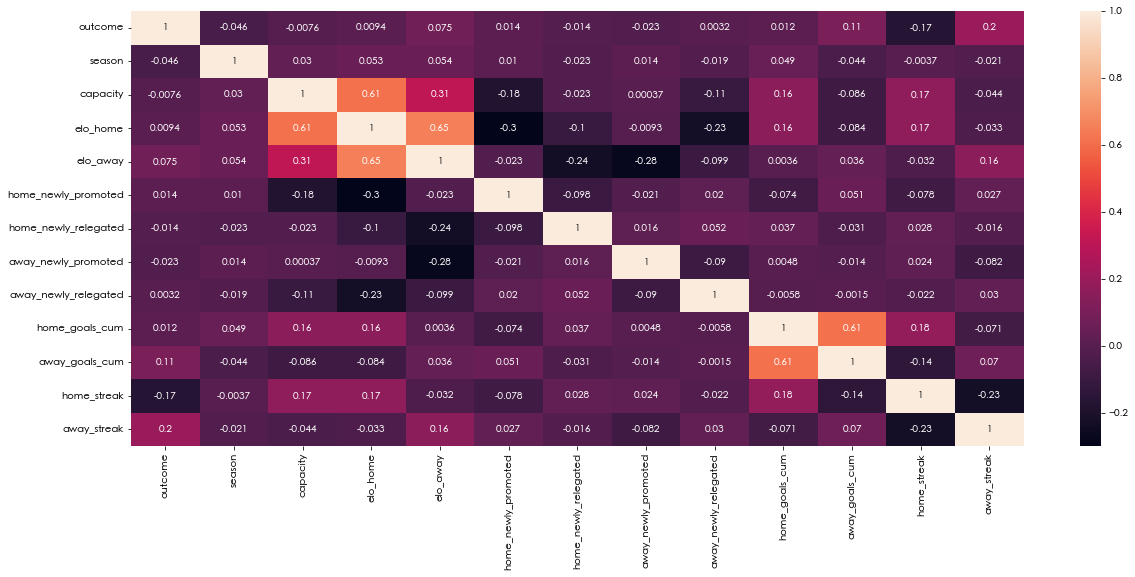

In [184]:
sns.heatmap(df_numeric.corr(), annot=True)

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
X = df_numeric.drop(columns=['outcome'])
y = df_numeric.outcome

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

# Models

In [192]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

## Logistic regression

In [215]:
logreg = linear_model.LogisticRegression().fit(X_train, y_train)

In [216]:
logreg.score(X_test, y_test)

0.6496353985812788

In [217]:
logreg.score(X_train, y_train)

0.6482377160999082

In [218]:
y_pred = logreg.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[1,2,3,4])

array([[   0,  583, 1205,   22],
       [   0, 1384, 2399,   62],
       [   0, 1130, 8218,   40],
       [   0,  766,  856, 3494]])

In [219]:
# no-score draw (1), score draw (2), home win (3) or away win (4)
y.value_counts()

3    46760
4    25830
2    18982
1     9221
Name: outcome, dtype: int64

In [220]:
pd.Series(y_pred).value_counts()

3    12678
2     3863
4     3618
dtype: int64

In [233]:
probs = logreg.predict_proba(X)

In [234]:
probs

array([[1.61700957e-01, 4.20755473e-01, 1.64196289e-01, 2.53347282e-01],
       [1.95205320e-01, 3.29304495e-01, 3.36911280e-01, 1.38578906e-01],
       [1.78215066e-01, 3.04120935e-01, 4.25740907e-01, 9.19230929e-02],
       ...,
       [1.57009703e-07, 2.70235689e-07, 3.03125941e-14, 9.99999573e-01],
       [1.20350669e-01, 3.26498469e-01, 2.26554184e-01, 3.26596678e-01],
       [8.13846521e-03, 1.59041050e-02, 9.75711331e-01, 2.46098606e-04]])

## SVM

In [207]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [212]:
linsvc = make_pipeline(StandardScaler(), LinearSVC(tol=1e-5))
linsvc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(tol=1e-05))])

In [225]:
linsvc.score(X_test, y_test)

0.6363410883476363

In [226]:
y_pred = linsvc.predict(X_test)
confusion_matrix(y_test, y_pred, labels=[1,2,3,4])

array([[   0,    0, 1713,   97],
       [   0,    0, 3621,  224],
       [   0,    0, 9246,  142],
       [   0,    0, 1534, 3582]])

In [227]:
y_test.value_counts()

3    9388
4    5116
2    3845
1    1810
Name: outcome, dtype: int64

## SGD classifier

In [228]:
from sklearn.linear_model import SGDClassifier

In [229]:
sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
sgd.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [230]:
sgd.score(X_test, y_test)

0.6387221588372439

In [231]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 138,  341, 1247,   84],
       [ 271,  903, 2524,  147],
       [ 171,  761, 8317,  139],
       [ 190,  467,  941, 3518]])